# Functions for creating signals and networks, and for evolving d_ff and d_fb

In [1]:
import numpy as np
import nengo
from nengolib.signal import s, z
from nengo.utils.numpy import rmse
import matplotlib.pyplot as plt
import seaborn as sns
from pathos import multiprocessing as mp
from nengolib.signal import LinearSystem
import nengolib
import copy
from bioneuron_oracle import BahlNeuron
%matplotlib inline

/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


In [2]:
def get_signals(
    signal_type,
    network_seed=1,
    sim_seed=1,
    freq=1,
    signal_seed=1,
    t_transient=1.0,
    t_final=1.0,
    max_freq=1,
    rms=1,
    tau=0.1,
    dt=0.001):

    with nengo.Network(seed=network_seed) as network:
        if signal_type == 'sinusoids':
            stim = nengo.Node(lambda t: 
                np.cos(freq * (t)))
        elif signal_type == 'white_noise':
            stim = nengo.Node(nengo.processes.WhiteSignal(
                period=t_final, high=max_freq, rms=rms, seed=signal_seed, y0=0))
        delayed_stim = nengo.Node(size_in=1)
        nengo.Connection(stim, delayed_stim, synapse=nengolib.synapses.DiscreteDelay(int(t_transient/dt)))
        integ = nengo.Node(size_in=1)
        nengo.Connection(delayed_stim, integ, synapse=1/s)
        p_stim = nengo.Probe(delayed_stim, synapse=None)
        p_integ = nengo.Probe(integ, synapse=None)
    with nengo.Simulator(network, dt=dt, progress_bar=False, seed=sim_seed) as sim:
        sim.run(t_final)
    transient = np.array(0.0 * np.arange(0, t_transient+dt, dt))
    stimulus = np.hstack((transient, sim.data[p_stim][:,0]))
    integral = np.hstack((transient, sim.data[p_integ][:,0]))
    norm_stimulus = np.max(np.abs(stimulus))
    norm_integral = np.max(np.abs(integral))
    stimulus /= norm_stimulus
    integral /= norm_integral    

    return stimulus, integral, norm_stimulus, norm_integral

In [3]:
def make_network(
    pre_neurons=100,
    bio_neurons=100,
    tau=0.1,
    dt=0.001,
    min_rate=150,
    max_rate=200,
    radius=1,
    dim=1,
    pre_seed=1,
    bio_seed=2,
    conn_seed=3,
    network_seed=4,
    sim_seed=5,
    post_seed=6,
    inter_seed=7,
    conn2_seed=9,
    conn3_seed=10,
    bio_type=nengo.LIF(),
    inter_type=nengo.LIF(),
    signal=[],
    integral=[],
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    d_feedforward=np.zeros((100, 1)),
    d_feedback=np.zeros((100,1)),
    d_inter=np.zeros((100,1)),
    H_ff=nengo.Lowpass(0.1)):

    """
    Define the network
    """
    with nengo.Network(seed=network_seed) as network:
        stim = nengo.Node(lambda t: signal[int(t/dt)])
        integ = nengo.Node(lambda t: integral[int(t/dt)])
        pre = nengo.Ensemble(
            n_neurons=pre_neurons,
            dimensions=dim,
            seed=pre_seed,
            neuron_type=nengo.LIF(),
            radius=radius,
            label='pre')
        bio = nengo.Ensemble(
            n_neurons=bio_neurons,
            dimensions=dim,
            seed=bio_seed,
            neuron_type=bio_type,
            radius=radius,
            max_rates=nengo.dists.Uniform(min_rate, max_rate),
            label='bio')
        pre_inter = nengo.Ensemble(  # currently unused
            n_neurons=pre_neurons,
            dimensions=dim,
            seed=pre_seed,
            neuron_type=nengo.LIF(),
            radius=radius,
            label='pre_inter')
        inter = nengo.Ensemble(
            n_neurons=bio_neurons,
            dimensions=dim,
            seed=bio_seed,
            neuron_type=inter_type,
            max_rates=nengo.dists.Uniform(min_rate, max_rate),
            radius=radius,
            label='inter')
        lif = nengo.Ensemble(
            n_neurons=bio_neurons,
            dimensions=dim,
            seed=bio_seed,
            max_rates=nengo.dists.Uniform(min_rate, max_rate),
            radius=radius,
            neuron_type=nengo.LIF(),
            label='lif')
        oracle = nengo.Node(size_in=dim)
        temp = nengo.Node(size_in=dim)
        temp2 = nengo.Node(size_in=dim)

        ff_solver = nengo.solvers.NoSolver(d_feedforward)
        fb_solver = nengo.solvers.NoSolver(d_feedback)
        inter_solver = nengo.solvers.NoSolver(d_inter) if not isinstance(d_inter, nengo.solvers.Solver) else d_inter  # lol 

        nengo.Connection(stim, pre, synapse=None)
        pre_bio = nengo.Connection(pre, bio,
            weights_bias_conn=True,
            seed=conn_seed,
            synapse=tau,
            transform=T_pre_bio)
        bio_bio = nengo.Connection(bio, bio,
            seed=conn2_seed,
            synapse=tau,
            solver=fb_solver,
            transform=T_bio_bio)

        pre_lif = nengo.Connection(pre, lif,
            synapse=tau,
            transform=T_pre_bio)
        nengo.Connection(lif, lif,
            synapse=tau)

        stim_oracle = nengo.Connection(stim, oracle,
            synapse=tau,  
            transform=T_stim_oracle) # connection for training H(s) w/ feedforward pass
        integ_oracle = nengo.Connection(integ, oracle,
            synapse=None,  
            transform=T_integ_oracle) # connection for training d_feedback w/ feedback pass 

        integ_inter = nengo.Connection(integ, inter,  # no H(s)
            seed=conn3_seed,
            synapse=None)
        nengo.Connection(inter, bio,
            seed=conn3_seed,
            synapse=tau,
            transform=T_inter_bio,
            solver=inter_solver)  

        conn_lif = nengo.Connection(lif, temp, synapse=tau)
        conn_inter = nengo.Connection(inter, temp2, synapse=tau)

        probe_bio_spikes = nengo.Probe(bio.neurons, 'spikes')
        probe_lif_spikes = nengo.Probe(lif.neurons, 'spikes')
        probe_lif_activity = nengo.Probe(lif.neurons, 'spikes', synapse=tau)
        probe_bio_activity = nengo.Probe(bio.neurons, 'spikes', synapse=H_ff)
        probe_oracle = nengo.Probe(oracle, synapse=H_ff)
        probe_bio = nengo.Probe(bio, synapse=tau, solver=ff_solver)
        probe_lif = nengo.Probe(lif, synapse=tau)
        probe_inter = nengo.Probe(inter, synapse=tau, solver=inter_solver)
        probe_inter_activity = nengo.Probe(inter.neurons, 'spikes', synapse=tau)
        probe_inter_spikes = nengo.Probe(inter.neurons, 'spikes', synapse=None)
        probe_pre = nengo.Probe(pre, synapse=tau)
        probe_integ = nengo.Probe(integ, synapse=tau)  # TODO: make sure unfiltered not needed
        probe_stim = nengo.Probe(stim, synapse=None)

    network.bio = bio
    network.conn_lif = conn_lif
    network.conn_inter = conn_inter
    network.bio_bio = bio_bio
    network.stim = stim
    network.integ = integ
    network.pre_bio = pre_bio
    network.pre_lif = pre_lif
    network.stim_oracle = stim_oracle
    network.integ_oracle = integ_oracle
    network.integ_inter = integ_inter
    network.probe_bio_spikes = probe_bio_spikes
    network.probe_lif_spikes = probe_lif_spikes
    network.probe_bio_activity = probe_bio_activity
    network.probe_oracle = probe_oracle
    network.probe_bio = probe_bio
    network.probe_lif = probe_lif
    network.probe_lif_activity = probe_lif_activity
    network.probe_inter = probe_inter
    network.probe_inter_activity = probe_inter_activity
    network.probe_inter_spikes = probe_inter_spikes
    network.probe_pre = probe_pre
    network.probe_integ = probe_integ
    network.probe_stim = probe_stim

    return network

In [4]:
def run_plot(network, t_transient, t_run, dt, sim_seed):
    
    with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
        sim.run(t_transient + t_test)
    
    times = sim.trange()[int(t_transient/dt):]
    xhat_bio = sim.data[network.probe_bio][int(t_transient/dt):]
    xhat_lif = sim.data[network.probe_lif][int(t_transient/dt):]
    xhat_inter = sim.data[network.probe_inter][int(t_transient/dt):]
    x_integ = sim.data[network.probe_integ][int(t_transient/dt):]
    target = sim.data[network.probe_oracle][int(t_transient/dt):]
    rmse_bio = rmse(xhat_bio, target)
    rmse_lif = rmse(xhat_lif, target)

    fig, ax = plt.subplots(1,1, figsize=(16,8))
    ax.plot(times, xhat_bio, label='bio, rmse=%.5f' % rmse_bio)
    ax.plot(times, xhat_lif, label='lif, rmse=%.5f' % rmse_lif)
#     ax.plot(times, xhat_inter, label='inter')
#     ax.plot(times, x_integ, label='integ')
    ax.plot(times, target, label='target')
    ax.set(xlabel='time (s)', ylabel='$\hat{x}(t)$')
    ax.legend()
    plt.show()

In [5]:
def test_n_trials(network, n_trials, t_transient, t_test, sim_seed,
                  network_seed, max_freq, rms, signal_seed, tau, dt):
    
    rmses = []
    for n in range(n_trials):
        print 'trial %s' %n
        signal_test, integral_test, norm_stim_test, norm_integ_test = get_signals(
            'white_noise', network_seed, sim_seed, 1, signal_seed+n,
            t_transient, t_test, max_freq, rms, tau, dt)
        with network:
            network.stim.output = lambda t: signal_test[int(t/dt)]
            network.integ.output = lambda t: integral_test[int(t/dt)]
            network.pre_bio.transform = tau*norm_stim_test/norm_integ_test
        with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:  #progress_bar=False, progress_bar=False, 
            sim.run(t_transient + t_test)
        xhat_bio = sim.data[network.probe_bio][int(t_transient/dt):]
        target = sim.data[network.probe_oracle][int(t_transient/dt):]
        rmses.append(rmse(xhat_bio, target))
        
    fig, ax = plt.subplots(1,1, figsize=(16,8))
    ax.hist(rmses)
    ax.set(title='mean rmse=%s' %np.average(rmses))
    plt.show()
    
    return np.array(rmses)

In [6]:
def build_filter(zeros, poles):
    """ create the transfer function from the passed constants to serve as the filter """
    built_filter = LinearSystem((zeros, poles, 1.0))
    built_filter /= built_filter.dcgain
    return built_filter

In [7]:
def train_feedforward(
    network,
    sim_seed,
    t_transient,
    t_final,
    dt,
    reg,
    n_processes,
    evo_popsize,
    evo_gen,
    evo_seed,
    zeros_init,
    poles_init,
    zeros_delta,
    poles_delta,
    bio_probe,  # probe of bioneuron activity (filtered spikes)
    target_probe):

    def evaluate(inputs):
        network=inputs[0]
        zeros = inputs[1][0]
        poles = inputs[1][1]
        bio_probe = inputs[2][0]
        target_probe = inputs[2][1]
        """
        ensure stim outputs the training signal and the bio/alif are assigned
        their particular readout filters, as well as other filters that have been
        trained already (these can't be fed into pool.evaluate() without _paramdict errors)
        """
        filt = build_filter(zeros, poles)
        with network:
            bio_probe.synapse = filt
        """
        run the simulation, collect filtered activites,
        and apply the oracle method to calculate readout decoders
        """
        with nengo.Simulator(network, dt=dt, progress_bar=False, seed=sim_seed) as sim:
            sim.run(t_transient+t_final)
        act_bio = sim.data[bio_probe][int(t_transient/dt):]
        target = sim.data[target_probe][int(t_transient/dt):]
        if np.sum(act_bio) > 0:
            d_bio = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
        else:
            d_bio = np.zeros((act_bio.shape[1], target.shape[1]))
        xhat_bio = np.dot(act_bio, d_bio)
        rmse_bio = rmse(target, xhat_bio)
        return rmse_bio

    def get_decoders(inputs, plot=False):
        network=inputs[0]
        zeros = inputs[1]
        poles = inputs[2]
        bio_probe = inputs[3]
        target_probe = inputs[4]
        """
        ensure stim outputs the training signal and the bio/alif are assigned
        their particular readout filters
        """
        filt = build_filter(zeros, poles)
        with network:
            bio_probe.synapse = filt
        """
        run the simulation, collect filtered activites,
        and apply the oracle method to calculate readout decoders
        """
        with nengo.Simulator(network, dt=dt, progress_bar=False, seed=sim_seed) as sim:
            sim.run(t_transient+t_final)
        act_bio = sim.data[bio_probe][int(t_transient/dt):]
        target = sim.data[target_probe][int(t_transient/dt):]
        if np.sum(act_bio) > 0:
            d_bio = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
        else:
            d_bio = np.zeros((act_bio.shape[1], target.shape[1]))
        xhat_bio = np.dot(act_bio, d_bio)
        rmse_bio = rmse(target, xhat_bio)
        if hasattr(network, 'probe_inter_activity'):
            integ = sim.data[network.probe_integ][int(t_transient/dt):]
            act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
            d_inter = nengo.solvers.LstsqL2(reg=reg)(act_inter, integ)[0]
            d_inter = d_inter.reshape((d_inter.shape[0],1))
            # d_inter = sim.data[network.conn_lif].weights.T
        else:
            d_inter = None

        return d_bio, d_inter

#     pool = mp.ProcessingPool(nodes=n_processes)
    rng = np.random.RandomState(seed=evo_seed)

    """ Initialize evolutionary population """
    filter_pop = []
    for p in range(evo_popsize):
        my_zeros= []
        my_poles = []
        for z in zeros_init:
            my_zeros.append(rng.uniform(-z, z))
        for p in poles_init:
            my_poles.append(rng.uniform(0, p))  # poles must be negative
        filter_pop.append([my_zeros, my_poles])


    """ Run evolutionary strategy """
    fit_vs_gen = []
    for g in range(evo_gen):
        print 'generation %s' %g
        probes = [bio_probe, target_probe]
        # reconfigure nengolib synapses to have propper attributes to be passed to pool.map()
        for probe in network.probes:
            if isinstance(probe.synapse, LinearSystem):
                try:
                    probe.synapse._paramdict = nengo.Lowpass(0.1)._paramdict
                    probe.synapse.tau = 0.1
                    probe.synapse.default_size_in = 1
                    probe.synapse.default_size_out = 1
                except:
                    continue
        for conn in network.connections:
            if isinstance(conn.synapse, LinearSystem):
                try:
                    conn.synapse._paramdict = nengo.Lowpass(0.1)._paramdict
                    conn.synapse.tau = 0.1
                    conn.synapse.default_size_in = 1
                    conn.synapse.default_size_out = 1
                except:
                    continue

        inputs = [[network, filter_pop[p], probes] for p in range(evo_popsize)]
        fitnesses = np.zeros((evo_popsize))
        for i, inpt in enumerate(inputs):
            fitnesses[i] = evaluate(inpt)
#         fitnesses = np.array(pool.map(evaluate, inputs))
        best_filter = filter_pop[np.argmin(fitnesses)]
        best_fitness = fitnesses[np.argmin(fitnesses)]
        fit_vs_gen.append([best_fitness])
        decay = np.exp(-g / 5.0)
        # decay = 1.0  # off
        """ repopulate filter pops with mutated copies of the best individual """
        filter_pop_new = []
        for p in range(evo_popsize):
            my_zeros = []
            my_poles = []
            for term in range(len(best_filter[0])):
                my_zeros.append(best_filter[0][term] + rng.normal(0, zeros_delta[term]) * decay)  # mutate
            for term in range(len(best_filter[1])):
                my_poles.append(best_filter[1][term] + rng.normal(0, poles_delta[term]) * decay)  # mutate	
            filter_pop_new.append([my_zeros, my_poles])
        filter_pop = filter_pop_new

    """ Grab the best filters and decoders and plot fitness vs generation """
    best_zeros = best_filter[0]
    best_poles = best_filter[1]
    best_d_bio, d_inter = get_decoders([network, best_zeros, best_poles, bio_probe, target_probe], plot=True)

    fit_vs_gen = np.array(fit_vs_gen)
    import matplotlib.pyplot as plt
    figure, ax1 = plt.subplots(1,1)
    ax1.plot(np.arange(0, evo_gen), fit_vs_gen)
    ax1.set(xlabel='Generation', ylabel='Fitness ($\hat{x}$ RMSE)', title='ff_evolution')
    ax1.legend()
    plt.show()
    
    figure, ax1 = plt.subplots(1,1)
    times = np.arange(0, 1e0, 1e-3)
    ax1.plot(times, build_filter(best_zeros, best_poles).impulse(len(times)), label='evolved')
    ax1.plot(times, nengolib.Lowpass(0.1).impulse(len(times)), label='lowpass')
    ax1.set(xlabel='time', ylabel='amplitude', title='H_ff')
    ax1.legend()
    plt.show()

    return best_zeros, best_poles, best_d_bio, d_inter

In [8]:
def train_feedback(
    network,
    sim_seed,
    t_transient,
    t_final,
    dt,
    reg,
    n_processes,
    evo_popsize,
    evo_gen,
    evo_seed,
    zeros_feedforward,
    poles_feedforward,
    d_feedforward,
    d_feedback_init,
    conn_feedback,
    decoders_delta,
    mutation_rate,
    bio_probe,
    target_probe):

    def evaluate(inputs):
        network=inputs[0]
        d_feedback = inputs[1]
        conn_feedback = inputs[2]
        bio_probe = inputs[3][0]
        zeros_feedforward = inputs[3][1]
        poles_feedforward = inputs[3][2]
        d_feedforward = inputs[3][3]
        target_probe = inputs[4]
        plot = inputs[5]

        """ set the readout filter and the recurrent bioneuron decoders"""
        filt = build_filter(zeros_feedforward, poles_feedforward)
        with network:
            bio_probe.synapse = filt
            conn_feedback.solver = nengo.solvers.NoSolver(d_feedback)
            # conn_feedback.solver.decoders_bio = d_feedback
        """
        run the simulation, collect filtered activites,
        and apply the oracle method to calculate readout decoders
        """
        with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:  # , progress_bar=False
            sim.run(t_transient+t_final)
        act_bio = sim.data[bio_probe][int(t_transient/dt):]
        target = sim.data[target_probe][int(t_transient/dt):]
        xhat_bio = np.dot(act_bio, d_feedforward)
        rmse_bio = rmse(target, xhat_bio)

        if plot:
            import matplotlib.pyplot as plt
            figure, ax1 = plt.subplots(1,1, figsize=(16,8))
            ax1.plot(sim.trange()[int(t_transient/dt):], xhat_bio, label='bio, rmse=%.5f' %rmse_bio)
            ax1.plot(sim.trange()[int(t_transient/dt):], target, label='oracle')
            ax1.set(xlabel='time (s)', ylabel='activity', title='fb_decodes')
            ax1.legend()
            plt.show()

        return rmse_bio

    pool = mp.ProcessingPool(nodes=n_processes)
    rng = np.random.RandomState(seed=evo_seed)

    """ Initialize evolutionary population """
    decoder_pop = []
    for p in range(evo_popsize):
        # my_decoders = rng.uniform(-10*decoders_delta, 10*decoders_delta, size=d_feedback_init.shape)
        # my_decoders = d_feedback_init + rng.uniform(-decoders_delta, decoders_delta, size=d_feedback_init.shape)
        d_feedback_delta = rng.normal(0, decoders_delta, size=d_feedback_init.shape)
        for dec in range(d_feedback_delta.shape[0]):
            for dim in range(d_feedback_delta.shape[1]):
                if rng.uniform(0.0, 1.0) > mutation_rate: # set to zero with prob = 1-mutation_rate
                    d_feedback_delta[dec][dim] = 0.0
        my_decoders = d_feedback_init + d_feedback_delta
        decoder_pop.append(my_decoders)

    """ Run evolutionary strategy """
    fit_vs_gen = []
    for g in range(evo_gen):
        print 'generation %s' %g
        # reconfigure nengolib synapses to have propper attributes to be passed to pool.map()
        for probe in network.probes:
            if isinstance(probe.synapse, LinearSystem):
                try:
                    probe.synapse._paramdict = nengo.Lowpass(0.1)._paramdict
                    probe.synapse.tau = 0.1
                    probe.synapse.default_size_in = 1
                    probe.synapse.default_size_out = 1
                except:
                    continue
        for conn in network.connections:
            if isinstance(conn.synapse, LinearSystem):
                try:
                    conn.synapse._paramdict = nengo.Lowpass(0.1)._paramdict
                    conn.synapse.tau = 0.1
                    conn.synapse.default_size_in = 1
                    conn.synapse.default_size_out = 1
                except:
                    continue
        readout_info = [bio_probe, zeros_feedforward, poles_feedforward, d_feedforward]
        inputs = [[network, decoder_pop[p], conn_feedback, readout_info, target_probe, False] for p in range(evo_popsize)]
#         fitnesses = np.zeros((evo_popsize))
#         for i, inpt in enumerate(inputs):
#             fitnesses[i] = evaluate(inpt)
        fitnesses = np.array(pool.map(evaluate, inputs))
        best_decoders = decoder_pop[np.argmin(fitnesses)]
        best_fitness = fitnesses[np.argmin(fitnesses)]
        fit_vs_gen.append([best_fitness])
        decay = np.exp(-g / 30.0)
        # decay = 1.0  # off
        """ repopulate decoders pops with mutated copies of the best individual """
        decoders_pop_new = []
        for p in range(evo_popsize):
            # my_decoders = best_decoders + rng.uniform(-decoders_delta, decoders_delta, size=best_decoders.shape) * decay
            # my_decoders = best_decoders + rng.normal(0, decoders_delta, size=best_decoders.shape) * decay
            d_feedback_delta = rng.normal(0, decoders_delta, size=d_feedback_init.shape) * decay
            for dec in range(d_feedback_delta.shape[0]):
                for dim in range(d_feedback_delta.shape[1]):
                    if rng.uniform(0.0, 1.0) > mutation_rate: # set to zero with prob = 1-mutation_rate
                        d_feedback_delta[dec][dim] = 0.0
            my_decoders = best_decoders + d_feedback_delta
            decoders_pop_new.append(my_decoders)
        decoder_pop = decoders_pop_new

    """ Grab the best recurrent decoders and plot training accuracy and fitness vs generation """
    d_feedback = best_decoders
    evaluate([network, d_feedback, conn_feedback, readout_info, target_probe, True])

    fit_vs_gen = np.array(fit_vs_gen)
    import matplotlib.pyplot as plt
    figure, ax1 = plt.subplots(1,1, figsize=(16,8))
    ax1.plot(np.arange(0, evo_gen), fit_vs_gen)
    ax1.set(xlabel='Generation', ylabel='Fitness ($\hat{x}$ RMSE)', title='evolution')
    ax1.legend()
    plt.show()

    return d_feedback

# LIF Testing

### Basic parameters

In [9]:
pre_neurons = 100
bio_neurons = 100
tau = 0.1
dt = 0.001
min_rate = 150
max_rate = 200
radius = 1
dim = 1
reg = 0.1
cutoff = 0.1
pre_seed = 1
bio_seed = 2
conn_seed = 3
network_seed = 4
sim_seed = 5
post_seed = 6
inter_seed = 7
conn2_seed = 9
conn3_seed = 10
bio_type =  nengo.LIF() # BahlNeuron() # nengo.AdaptiveLIF(tau_n=.01, inc_n=.05)
inter_type = nengo.LIF() # BahlNeuron() # nengo.AdaptiveLIF(tau_n=.01, inc_n=.05)

### Train cos(t), test cos(t)

In [10]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_train = 30.0
t_test = 10.0
signal_type_train = 'sinusoids'
signal_type_test = 'sinusoids'
seed_train = 3
seed_test = 2

signal_train, integral_train, norm_stim_train, norm_integ_train = get_signals(
    signal_type_train, network_seed, sim_seed, freq, seed_train, t_transient, t_train, max_freq, rms, tau, dt)
signal_test, integral_test, norm_stim_test, norm_integ_test = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)

/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


### Make a feedforward network

In [11]:
network = make_network(
    pre_neurons,
    bio_neurons,
    tau,
    dt,
    min_rate,
    max_rate,
    radius,
    dim,
    pre_seed,
    bio_seed,
    conn_seed,
    network_seed,
    sim_seed,
    post_seed,
    inter_seed,
    conn2_seed,
    conn3_seed,
    bio_type,
    inter_type,
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

### Compute d_feedforward and d_inter using (a) evaluation points or (b) oracle method

In [12]:
with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)

act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]
d_feedforward_eval_points = sim.data[network.conn_lif].weights.T
d_inter_eval_points = sim.data[network.conn_inter].weights.T
d_ff_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter_oracle = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral)[0]

# fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 16))
# rasterplot(sim.trange(), sim.data[network.probe_bio_activity], ax=ax)
# rasterplot(sim.trange(), sim.data[network.probe_lif_activity], ax=ax2)
# plt.show()

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:24.                                                 


### Feedback inter spikes to bio using d_feedforward_eval_points, readout using d_feedforward_eval_points

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:07.                                                 


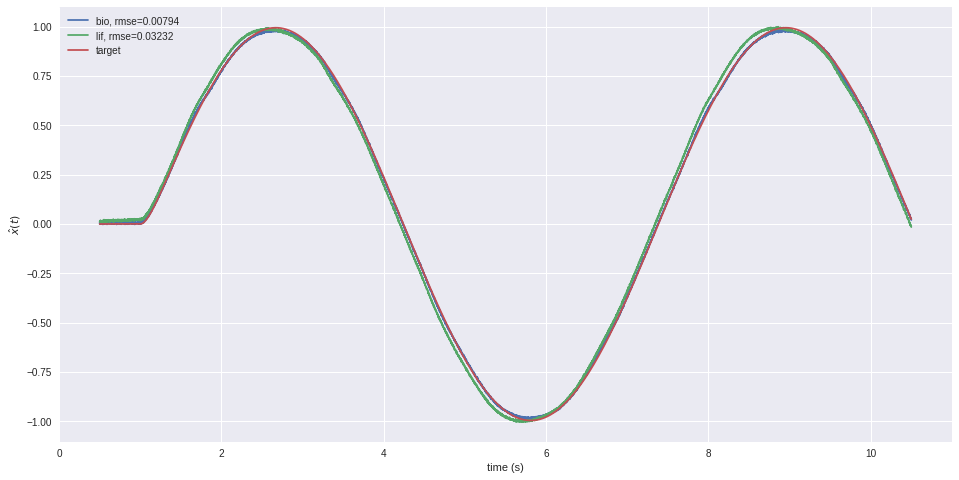

In [13]:
network = make_network(
    pre_neurons,
    bio_neurons,
    tau,
    dt,
    min_rate,
    max_rate,
    radius,
    dim,
    pre_seed,
    bio_seed,
    conn_seed,
    network_seed,
    sim_seed,
    post_seed,
    inter_seed,
    conn2_seed,
    conn3_seed,
    bio_type,
    inter_type,
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=tau/norm_stim_train,
    d_feedforward=d_feedforward_eval_points,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_feedforward_eval_points,
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

In [14]:
# from nengo.utils.matplotlib import rasterplot
# with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
#     sim.run(t_transient + t_train)
# fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 16))
# rasterplot(sim.trange(), sim.data[network.probe_bio_spikes], ax=ax)
# rasterplot(sim.trange(), sim.data[network.probe_lif_spikes], ax=ax2)
# plt.show()

### Feedback inter spikes to bio using d_feedforward_eval_points, readout bio using d_ff_oracle

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:09.                                                 


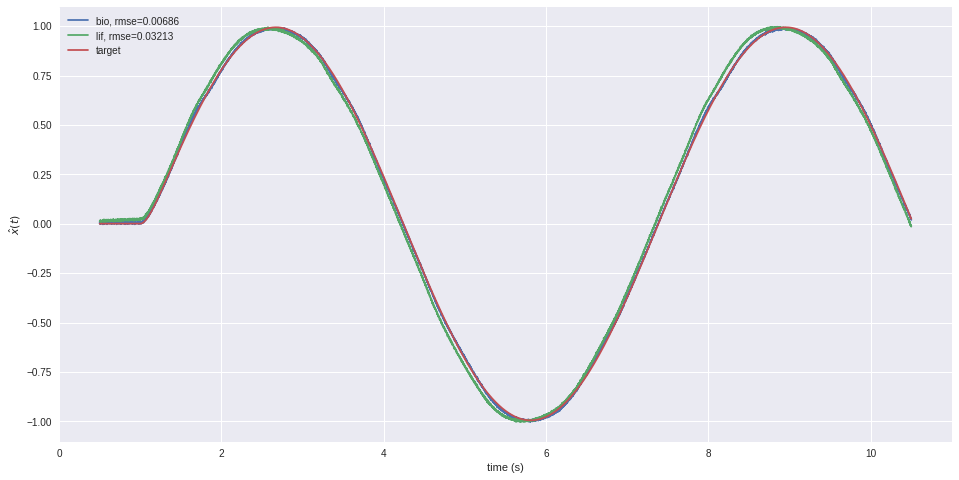

In [15]:
network = make_network(
    bio_seed=bio_seed,
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=tau*norm_stim_train/norm_integ_train,
    d_feedforward=d_ff_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_feedforward_eval_points,
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

### Feedback inter spikes to bio using d_inter_oracle, readout bio using d_ff_oracle, then compute a new set of d_ff_oracle given this (ideally driven) recurrent network 

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:21.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


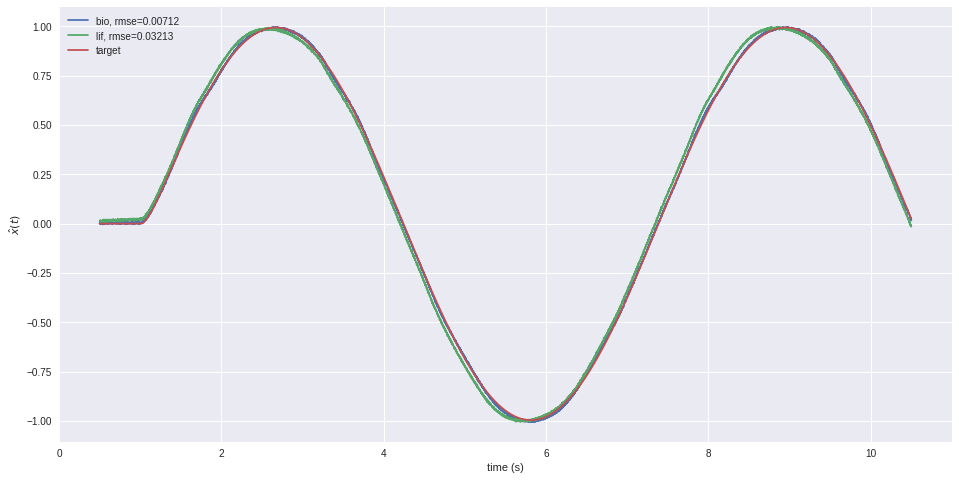

In [16]:
network = make_network(
    bio_seed=bio_seed,
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=tau*norm_stim_train/norm_integ_train,
    d_feedforward=d_ff_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,  # nengo.solvers.LstsqL2()
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
d_ff_oracle_2 = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

run_plot(network, t_transient, t_test, dt, sim_seed)

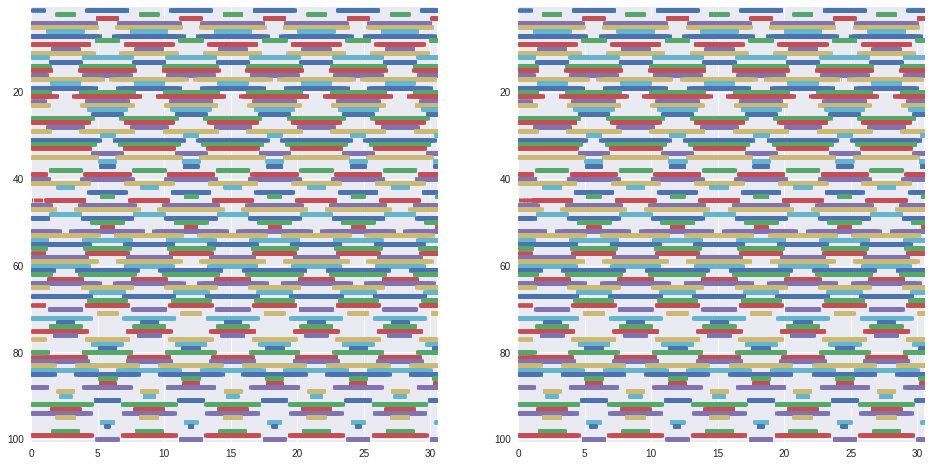

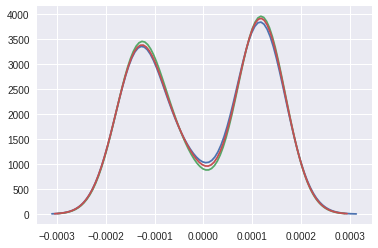

In [17]:
from nengo.utils.matplotlib import rasterplot
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(16, 8))
rasterplot(sim.trange(), sim.data[network.probe_bio_spikes], ax=ax)
rasterplot(sim.trange(), sim.data[network.probe_lif_spikes], ax=ax2)
plt.show()

sns.kdeplot(d_feedforward_eval_points.squeeze())
sns.kdeplot(d_ff_oracle.squeeze())
sns.kdeplot(d_ff_oracle_2.squeeze())

Seems like feeding back training spikes that are weighted by decoders computed with the oracle method (d_inter_oracle) can produce a stable integrator. Now the question is, can we use similarly computed weights on the actual recurrent bio spikes to produce a stable integrator?

### Remove training spikes, feedback bio spikes with d_fb = d_feedforward_eval_points, d_ff = d_ff_oracle to confirm network has expected connectivity and readout decoding works in recurrent case

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:12.                                                 


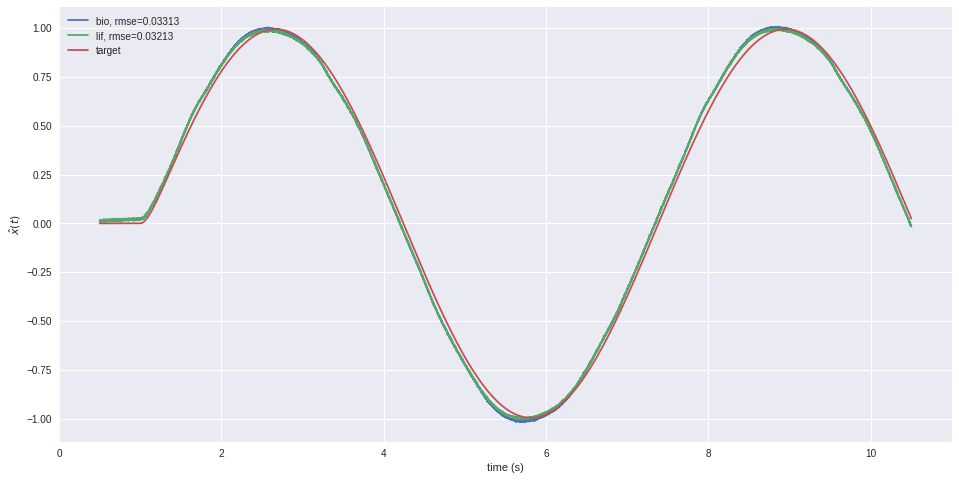

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:14.                                                 


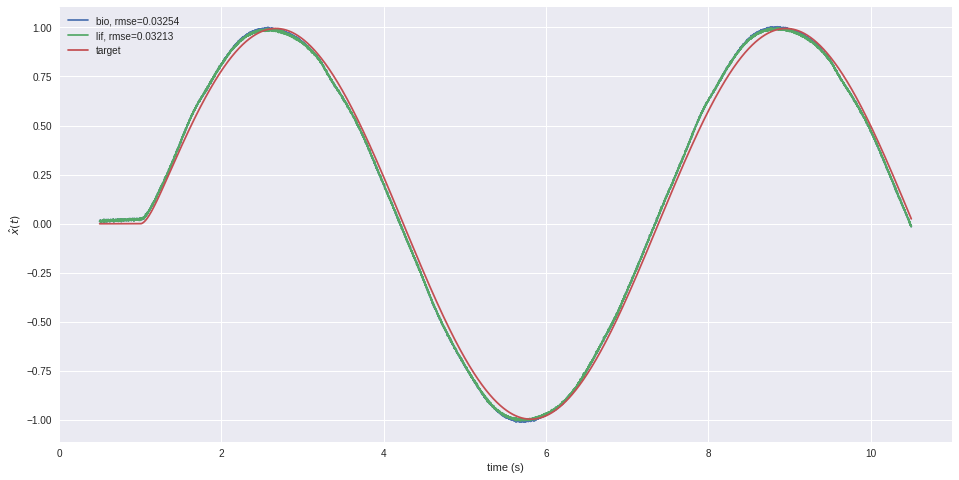

In [18]:
network = make_network(
    bio_seed=bio_seed,
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle,
    d_feedback=d_feedforward_eval_points,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_network(
    bio_seed=bio_seed,
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_feedforward_eval_points,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Readout decoding works well in the recurrent network when d_fb is calculated by normal nengo methods.

### d_ff = d_fb =  d_ff_oracle VS d_ff_oracle_2

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:11.                                                 


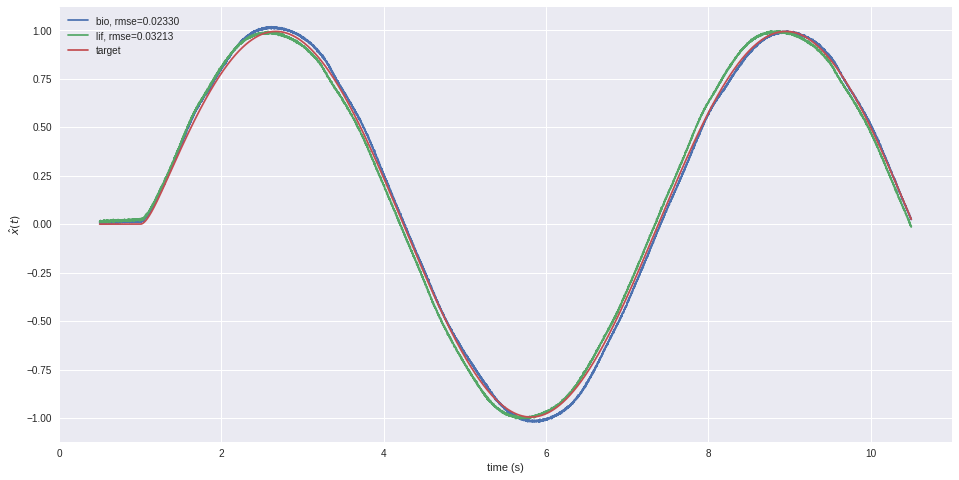

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:08.                                                 


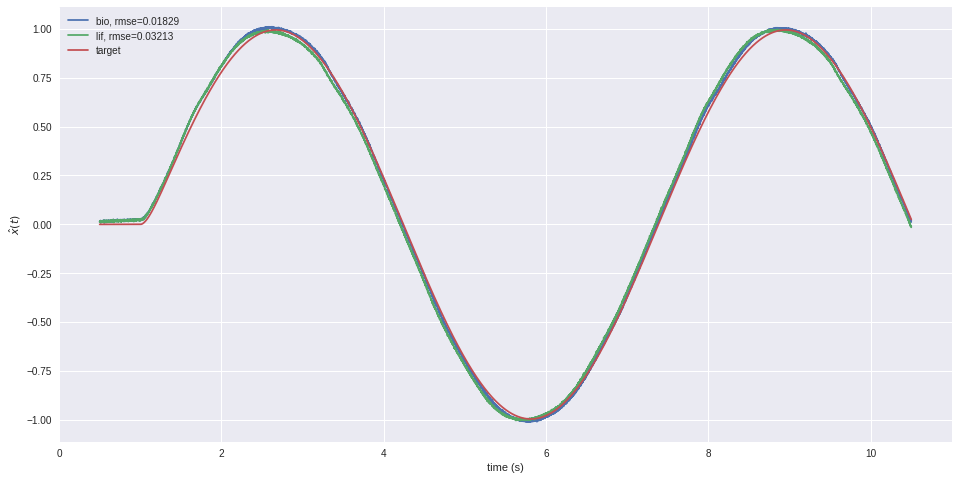

In [19]:
network = make_network(
    bio_seed=bio_seed,
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle,
    d_feedback=d_ff_oracle,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_network(
    bio_seed=bio_seed,
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_ff_oracle_2,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Using the feedforward decoders computed in the feedforward network for d_fb leads to similar error as the evaluation point decoders. The oracle decoders do about as well as the recurrent decoders, given sufficient training time

### Train cos(t), test white_noise

In [53]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_train = 30.0
t_test = 10.0
signal_type_train = 'sinusoids'
signal_type_test = 'white_noise'
seed_train = 3
seed_test = 2

signal_train, integral_train, norm_stim_train, norm_integ_train = get_signals(
    signal_type_train, network_seed, sim_seed, freq, seed_train, t_transient, t_train, max_freq, rms, tau, dt)
signal_test, integral_test, norm_stim_test, norm_integ_test = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:30.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:26.                                                 


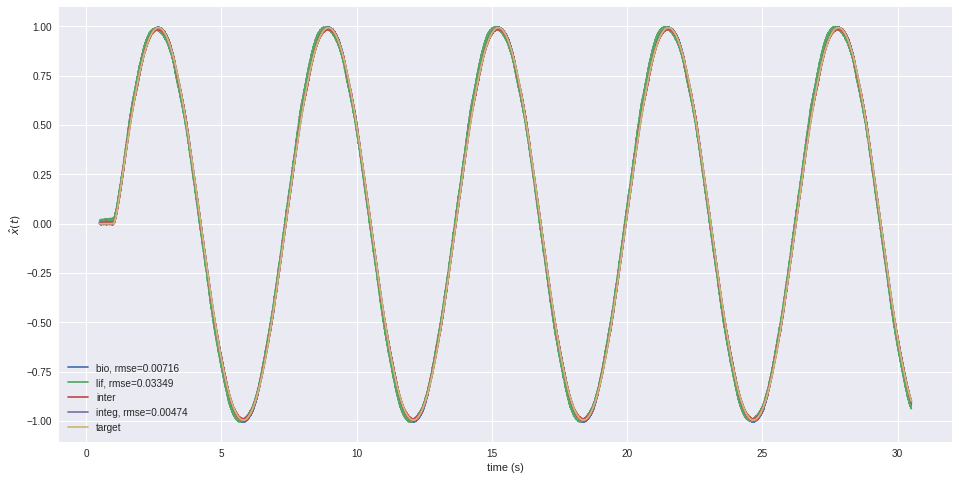

In [54]:
network = make_network(
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]
d_feedforward_eval_points = sim.data[network.conn_lif].weights.T
d_inter_eval_points = sim.data[network.conn_inter].weights.T
d_ff_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter_oracle = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral)[0]

network = make_network(
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=tau*norm_stim_train/norm_integ_train,
    d_feedforward=d_ff_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
d_ff_oracle_2 = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

times = sim.trange()[int(t_transient/dt):]
xhat_bio = sim.data[network.probe_bio][int(t_transient/dt):]
xhat_lif = sim.data[network.probe_lif][int(t_transient/dt):]
xhat_inter = sim.data[network.probe_inter][int(t_transient/dt):]
x_integ = sim.data[network.probe_integ][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integ = sim.data[network.probe_integ][int(t_transient/dt):]
rmse_bio = rmse(xhat_bio, target)
rmse_lif = rmse(xhat_lif, target)
rmse_inter = rmse(xhat_inter, integ)

fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.plot(times, xhat_bio, label='bio, rmse=%.5f' % rmse_bio)
ax.plot(times, xhat_lif, label='lif, rmse=%.5f' % rmse_lif)
ax.plot(times, xhat_inter, label='inter')
ax.plot(times, x_integ, label='integ, rmse=%.5f' % rmse_inter)
ax.plot(times, target, label='target')
ax.set(xlabel='time (s)', ylabel='$\hat{x}(t)$')
ax.legend()
plt.show()

### Test accuracy of recurrent network with oracle decoders and training spikes

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:12.                                                 


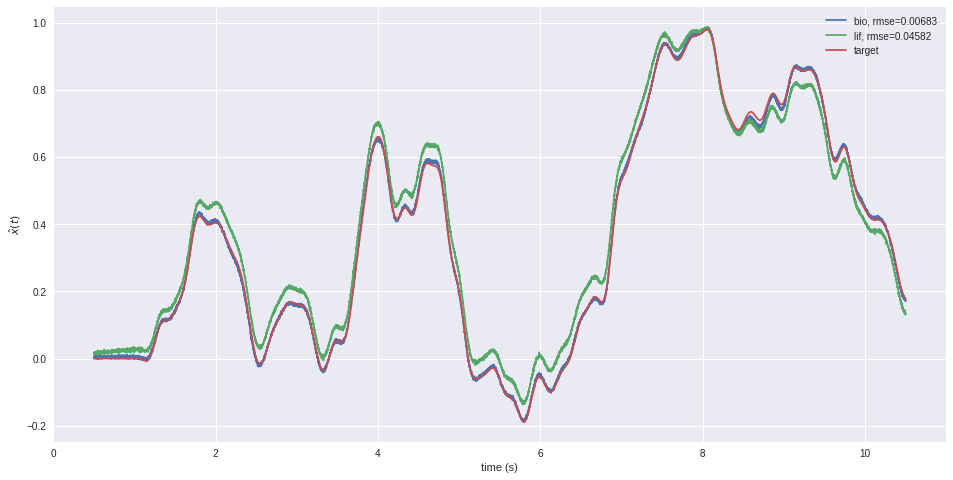

In [55]:
network = make_network(
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle_2,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_ff_oracle,
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

### Test accuracy of recurrent network with oracle decoders and recurrent spikes

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:08.                                                 


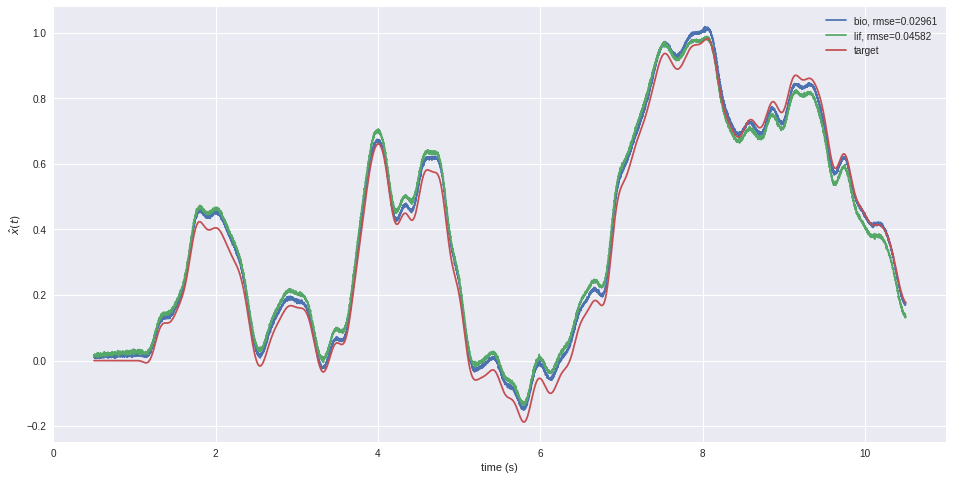

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:09.                                                 


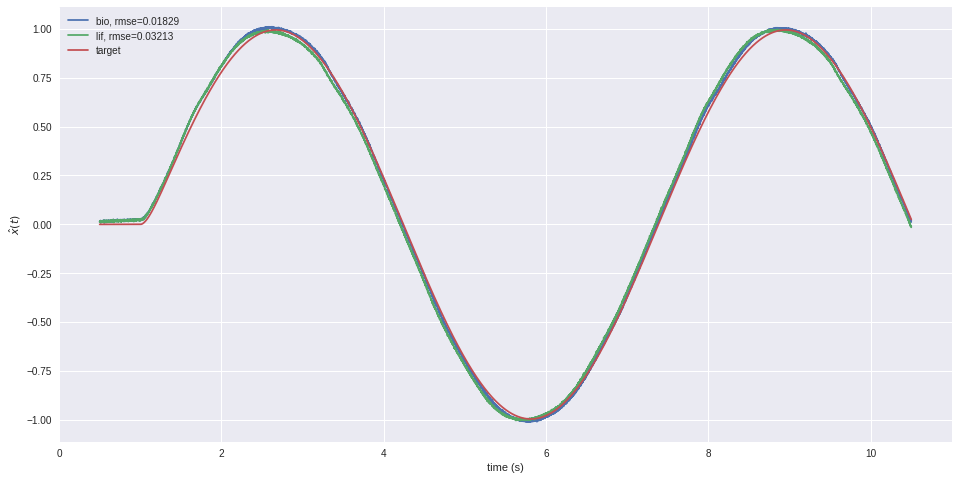

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:12.                                                 


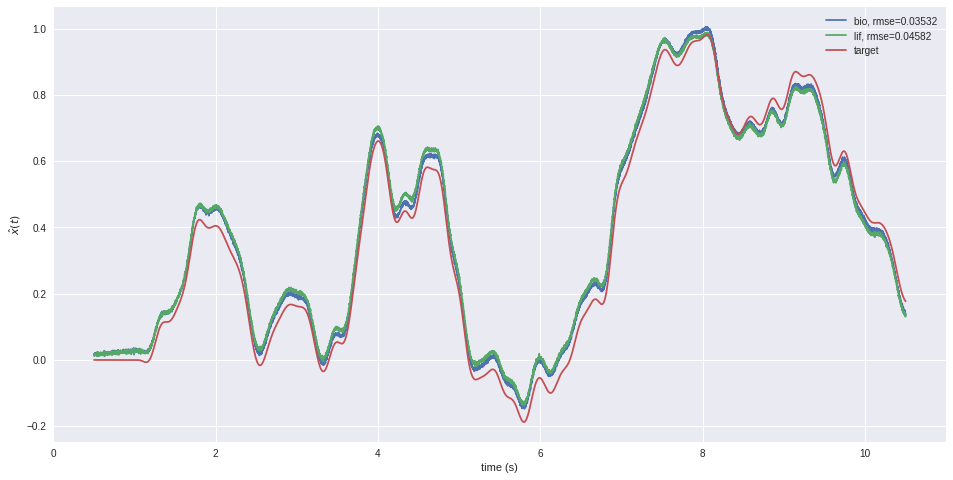

In [56]:
network = make_network(
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle,
    d_feedback=d_ff_oracle,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_network(
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_train/norm_integ_train,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_ff_oracle_2,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_network(
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_ff_oracle_2,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

### Train white_noise, test white_noise

In [47]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_train = 30.0
t_test = 10.0
signal_type_train = 'white_noise'
signal_type_test = 'white_noise'
seed_train = 3
seed_test = 2

signal_train, integral_train, norm_stim_train, norm_integ_train = get_signals(
    signal_type_train, network_seed, sim_seed, freq, seed_train, t_transient, t_train, max_freq, rms, tau, dt)
signal_test, integral_test, norm_stim_test, norm_integ_test = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:30.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:22.                                                 


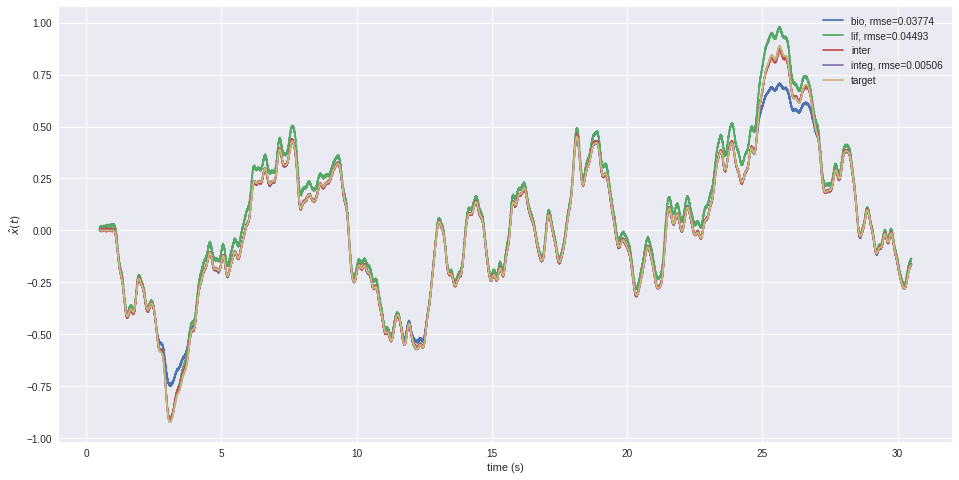

In [48]:
network = make_network(
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]
d_feedforward_eval_points = sim.data[network.conn_lif].weights.T
d_inter_eval_points = sim.data[network.conn_inter].weights.T
d_ff_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter_oracle = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral)[0]

network = make_network(
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=tau*norm_stim_train/norm_integ_train,
    d_feedforward=d_ff_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
d_ff_oracle_2 = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

times = sim.trange()[int(t_transient/dt):]
xhat_bio = sim.data[network.probe_bio][int(t_transient/dt):]
xhat_lif = sim.data[network.probe_lif][int(t_transient/dt):]
xhat_inter = sim.data[network.probe_inter][int(t_transient/dt):]
x_integ = sim.data[network.probe_integ][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integ = sim.data[network.probe_integ][int(t_transient/dt):]
rmse_bio = rmse(xhat_bio, target)
rmse_lif = rmse(xhat_lif, target)
rmse_inter = rmse(xhat_inter, integ)

fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.plot(times, xhat_bio, label='bio, rmse=%.5f' % rmse_bio)
ax.plot(times, xhat_lif, label='lif, rmse=%.5f' % rmse_lif)
ax.plot(times, xhat_inter, label='inter')
ax.plot(times, x_integ, label='integ, rmse=%.5f' % rmse_inter)
ax.plot(times, target, label='target')
ax.set(xlabel='time (s)', ylabel='$\hat{x}(t)$')
ax.legend()
plt.show()

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


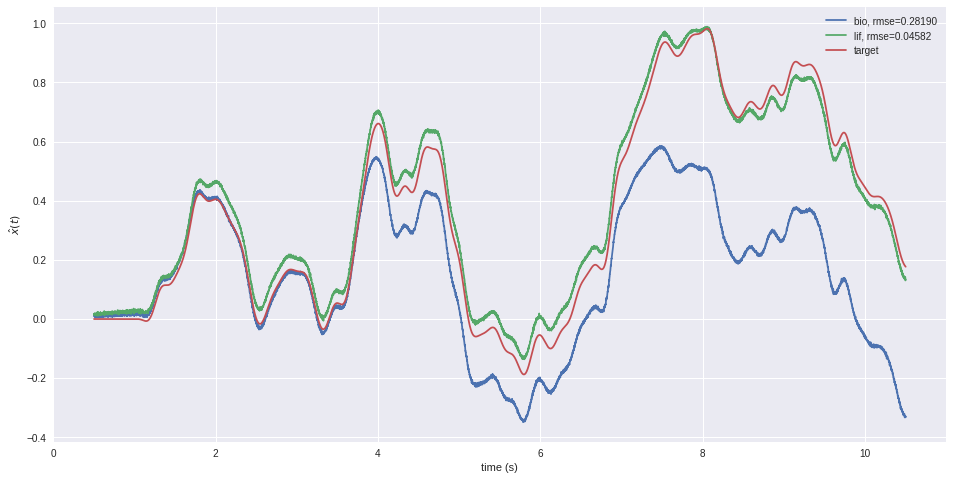

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:09.                                                 


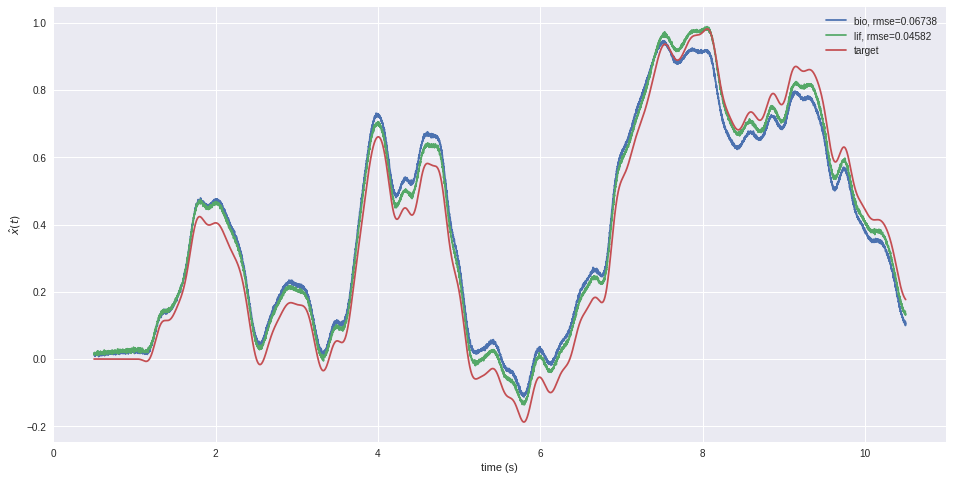

In [49]:
network = make_network(
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle,
    d_feedback=d_ff_oracle,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_network(
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_ff_oracle_2,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Seems like training with white noise leads to higher errors on test signals

# ALIF Training

In [72]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_train = 10.0
t_test = 10.0
signal_type_train = 'sinusoids'
signal_type_test = 'white_noise'
seed_train = 3
seed_test = 2

signal_train, integral_train, norm_stim_train, norm_integ_train = get_signals(
    signal_type_train, network_seed, sim_seed, freq, seed_train, t_transient, t_train, max_freq, rms, tau, dt)
signal_test, integral_test, norm_stim_test, norm_integ_test = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:14.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:11.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:07.                                                 


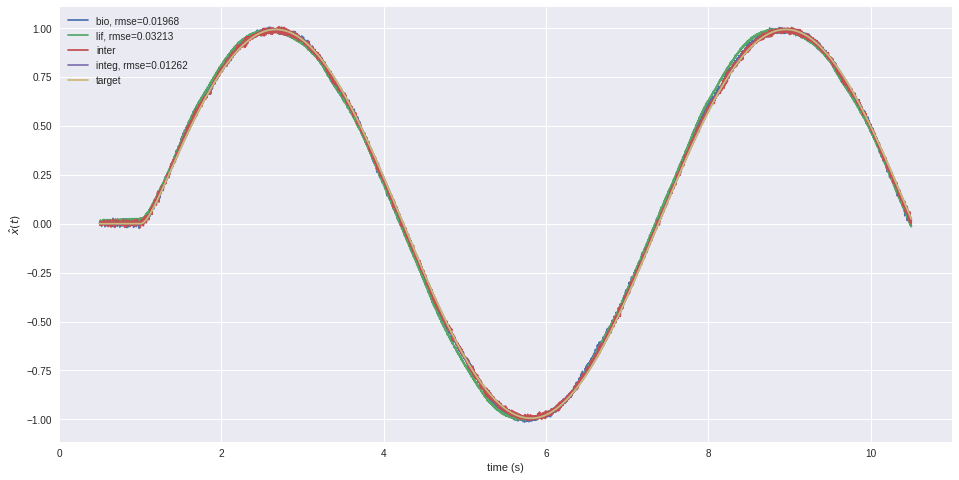

In [73]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]
d_feedforward_eval_points = sim.data[network.conn_lif].weights.T
d_inter_eval_points = sim.data[network.conn_inter].weights.T
d_ff_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter_oracle = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral)[0]

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=tau*norm_stim_train/norm_integ_train,
    d_feedforward=d_ff_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
d_ff_oracle_2 = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_test)

times = sim.trange()[int(t_transient/dt):]
xhat_bio = sim.data[network.probe_bio][int(t_transient/dt):]
xhat_lif = sim.data[network.probe_lif][int(t_transient/dt):]
xhat_inter = sim.data[network.probe_inter][int(t_transient/dt):]
x_integ = sim.data[network.probe_integ][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integ = sim.data[network.probe_integ][int(t_transient/dt):]
rmse_bio = rmse(xhat_bio, target)
rmse_lif = rmse(xhat_lif, target)
rmse_inter = rmse(xhat_inter, integ)

fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.plot(times, xhat_bio, label='bio, rmse=%.5f' % rmse_bio)
ax.plot(times, xhat_lif, label='lif, rmse=%.5f' % rmse_lif)
ax.plot(times, xhat_inter, label='inter')
ax.plot(times, x_integ, label='integ, rmse=%.5f' % rmse_inter)
ax.plot(times, target, label='target')
ax.set(xlabel='time (s)', ylabel='$\hat{x}(t)$')
ax.legend()
plt.show()

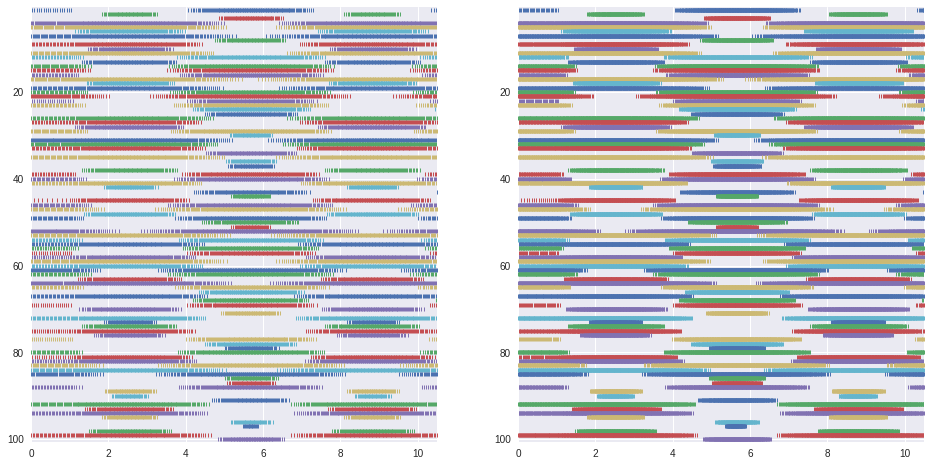

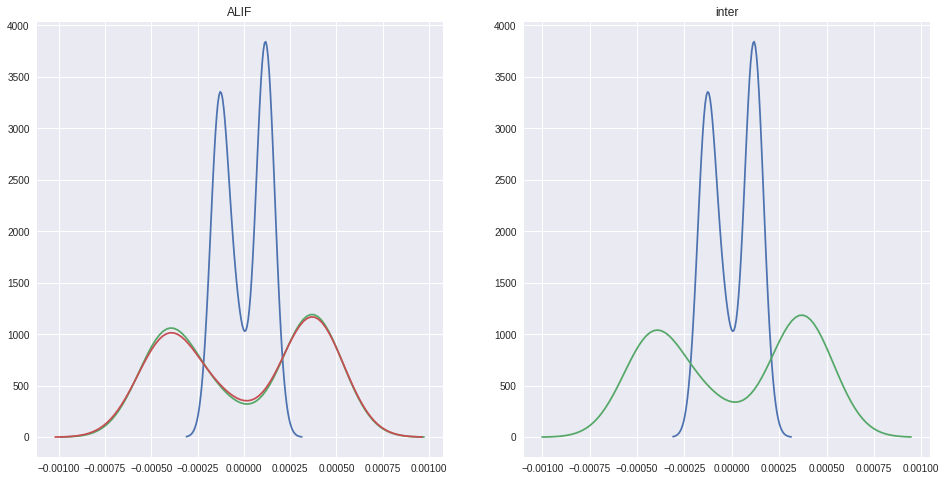

In [74]:
from nengo.utils.matplotlib import rasterplot
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
rasterplot(sim.trange(), sim.data[network.probe_bio_spikes], ax=ax[0])
rasterplot(sim.trange(), sim.data[network.probe_lif_spikes], ax=ax[1])
plt.show()

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(16, 8))
sns.kdeplot(d_feedforward_eval_points.squeeze(), ax=ax)
sns.kdeplot(d_ff_oracle.squeeze(), ax=ax)
sns.kdeplot(d_ff_oracle_2.squeeze(), ax=ax)
sns.kdeplot(d_inter_eval_points.squeeze(), ax=ax2)
sns.kdeplot(d_inter_oracle.squeeze(), ax=ax2)
ax.set(title='ALIF')
ax2.set(title='inter')
plt.show()

### Test accuracy of recurrent network with oracle decoders and recurrent spikes,  comparing d_fb = d_ff_oracle vs d_fb = d_ff_oracle_2

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


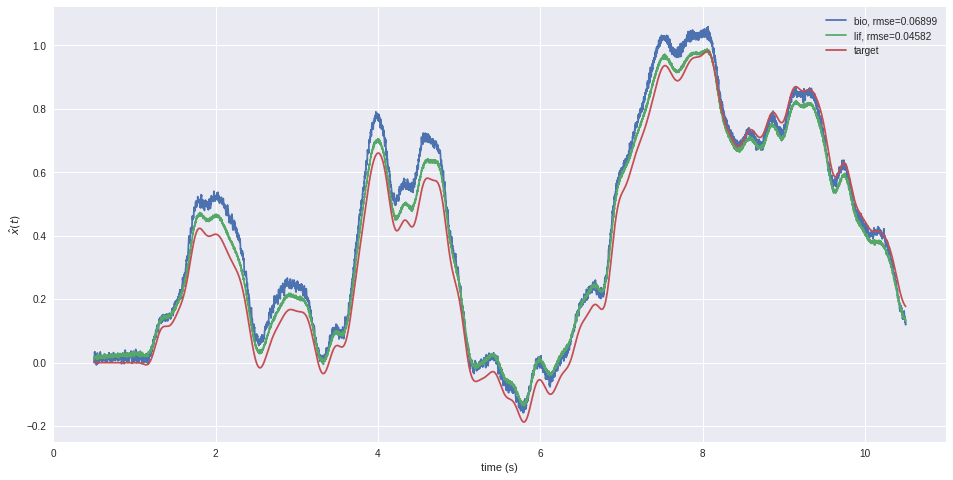

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


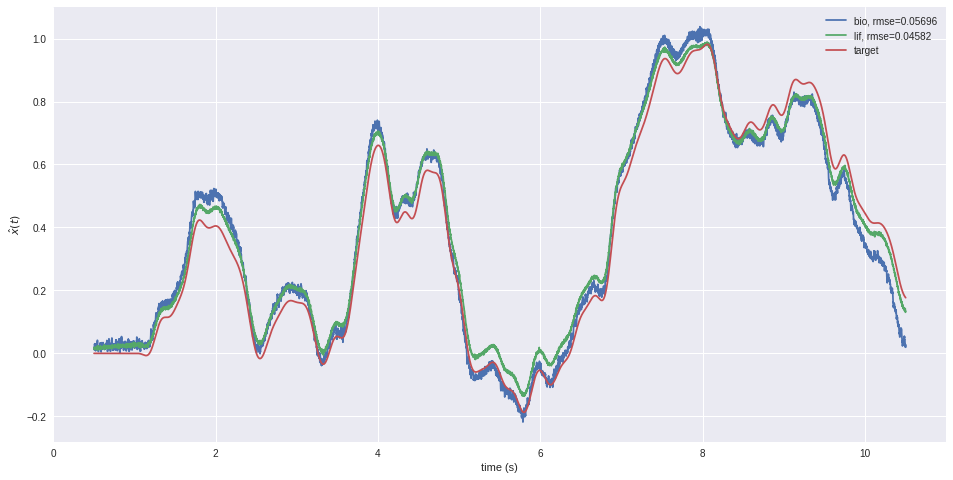

In [76]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle,
    d_feedback=d_ff_oracle,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_ff_oracle_2,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

### Test on new white_noise signal

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:09.                                                 


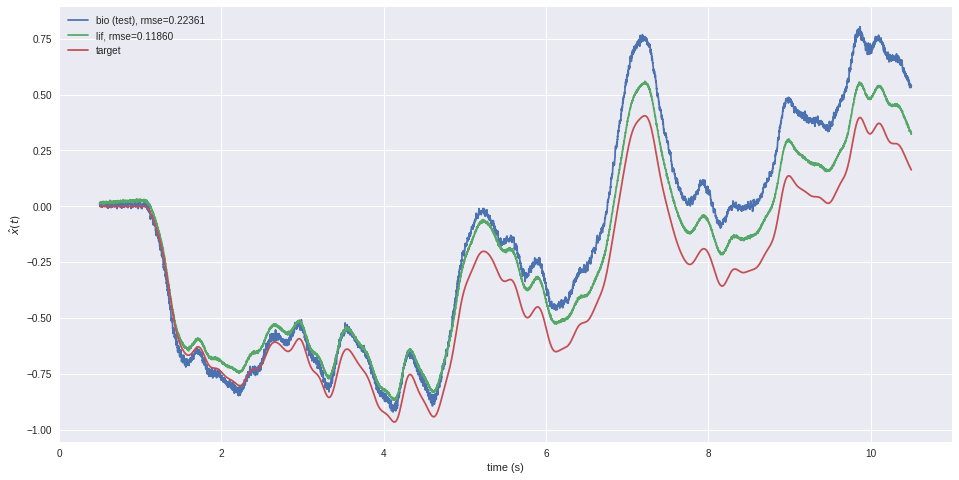

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:09.                                                 


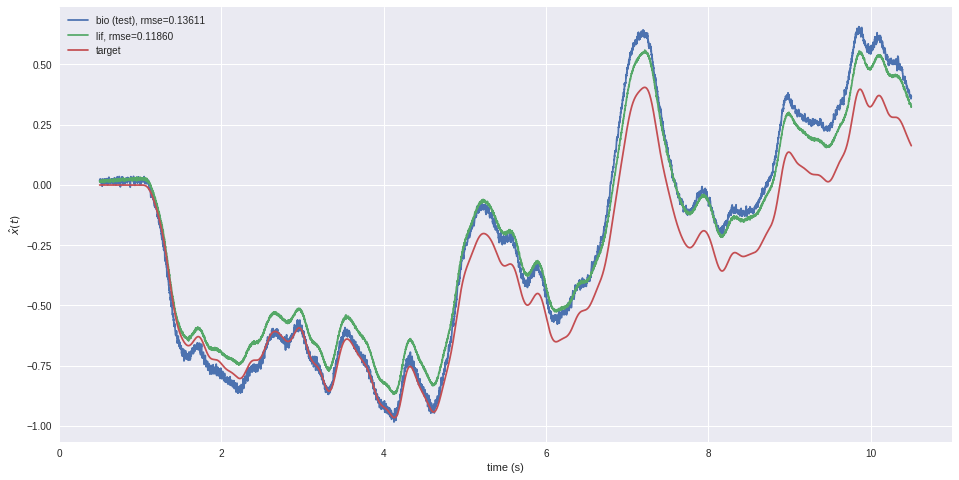

In [31]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_test = 10.0
signal_type_test = 'white_noise'
seed_test = 1

signal_test_2, integral_test_2, norm_stim_test_2, norm_integ_test_2 = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test_2,
    integral=integral_test_2,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test_2/norm_integ_test_2,
    d_feedforward=d_ff_oracle,
    d_feedback=d_ff_oracle,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test_2,
    integral=integral_test_2,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test_2/norm_integ_test_2,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_ff_oracle_2,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

### Train white_noise, test_white_noise

In [32]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_train = 10.0
t_test = 10.0
signal_type_train = 'white_noise'
signal_type_test = 'white_noise'
seed_train = 3
seed_test = 2

signal_train, integral_train, norm_stim_train, norm_integ_train = get_signals(
    signal_type_train, network_seed, sim_seed, freq, seed_train, t_transient, t_train, max_freq, rms, tau, dt)
signal_test, integral_test, norm_stim_test, norm_integ_test = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:13.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:08.                                                 


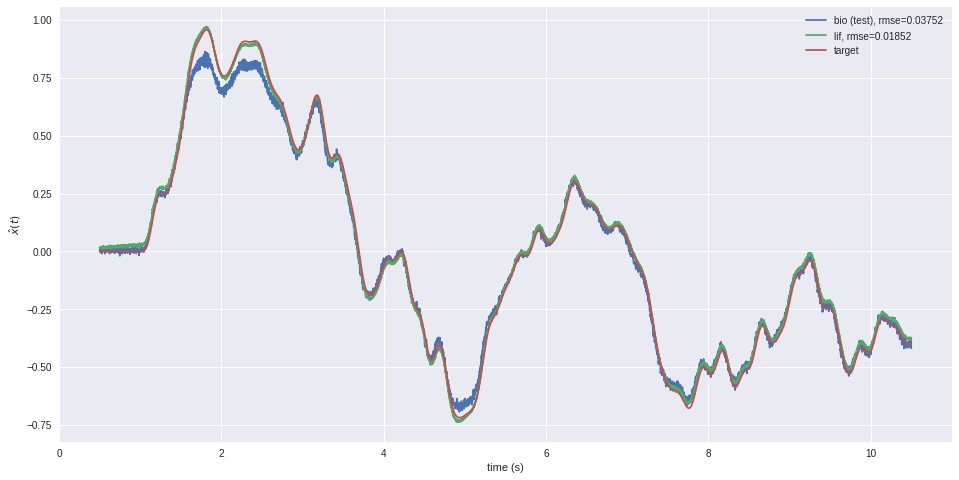

In [33]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]
d_feedforward_eval_points = sim.data[network.conn_lif].weights.T
d_inter_eval_points = sim.data[network.conn_inter].weights.T
d_ff_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter_oracle = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral)[0]

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=tau*norm_stim_train/norm_integ_train,
    d_feedforward=d_ff_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
d_ff_oracle_2 = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

run_plot(network, t_transient, t_test, dt, sim_seed)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:11.                                                 


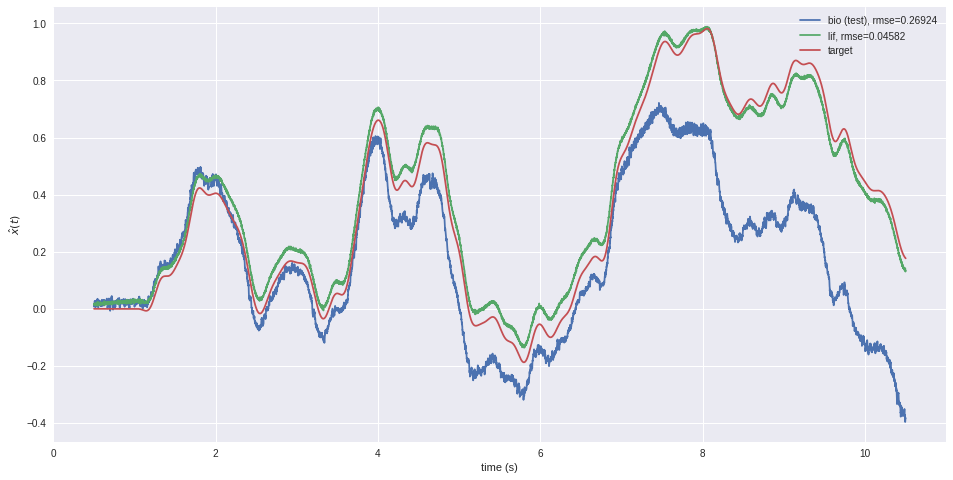

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:08.                                                 


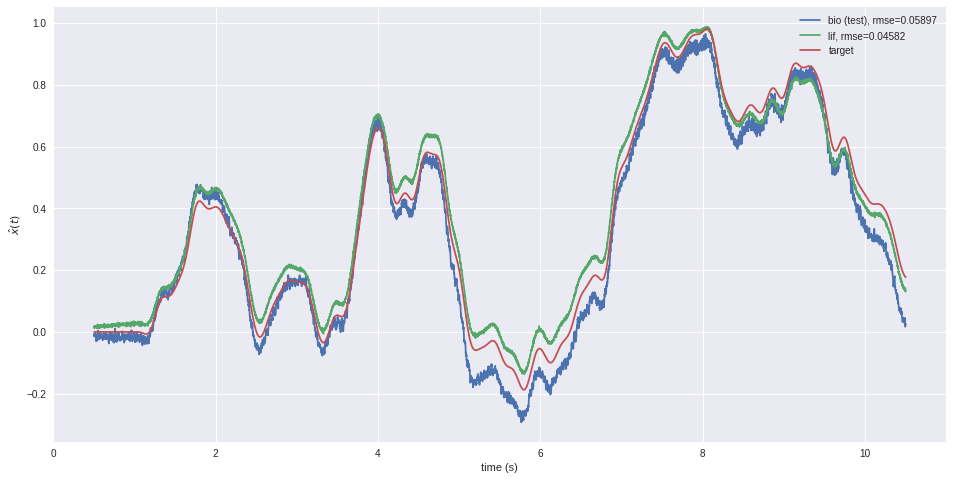

In [34]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle,
    d_feedback=d_ff_oracle,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_ff_oracle_2,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)


Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


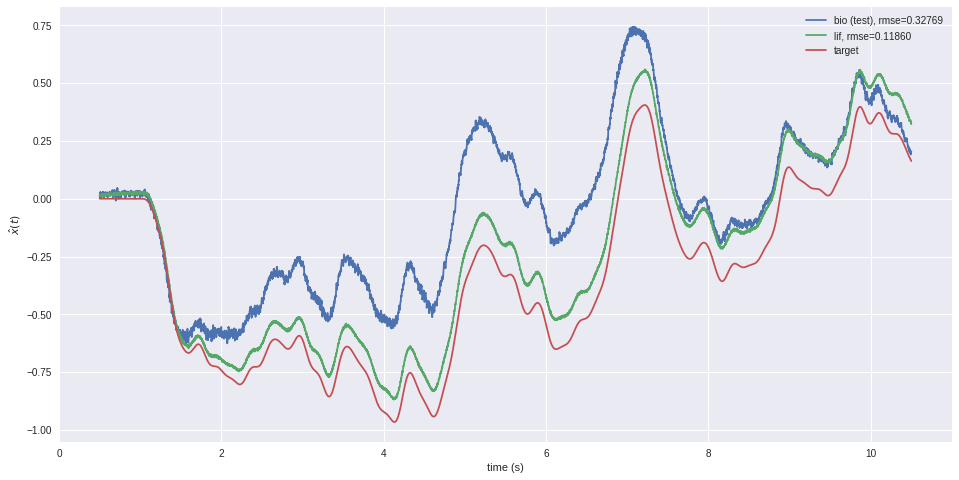

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:11.                                                 


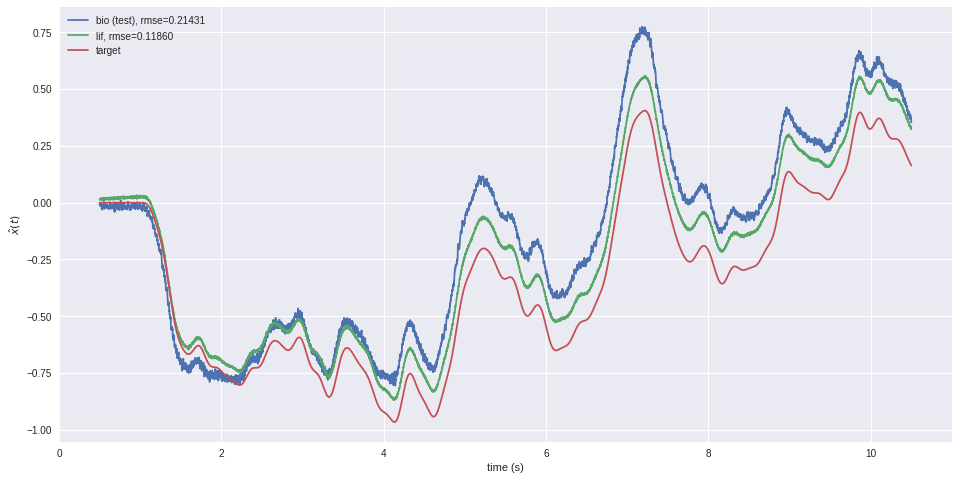

In [35]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_test = 10.0
signal_type_test = 'white_noise'
seed_test = 1

signal_test_2, integral_test_2, norm_stim_test_2, norm_integ_test_2 = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test_2,
    integral=integral_test_2,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test_2/norm_integ_test_2,
    d_feedforward=d_ff_oracle,
    d_feedback=d_ff_oracle,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test_2,
    integral=integral_test_2,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test_2/norm_integ_test_2,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_ff_oracle_2,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

White noise training seems significantly worse than cos(t) training

### bio_type = ALIF(), inter_type = LIF()

In [39]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_train = 30.0
t_test = 10.0
signal_type_train = 'white_noise'
signal_type_test = 'white_noise'
seed_train = 3
seed_test = 2

signal_train, integral_train, norm_stim_train, norm_integ_train = get_signals(
    signal_type_train, network_seed, sim_seed, freq, seed_train, t_transient, t_train, max_freq, rms, tau, dt)
signal_test, integral_test, norm_stim_test, norm_integ_test = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:17.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:29.                                                 


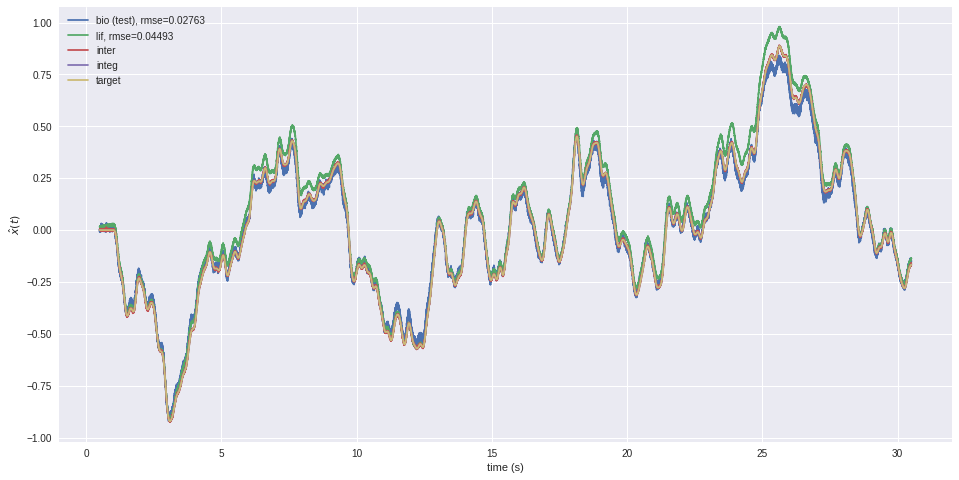

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:07.                                                 


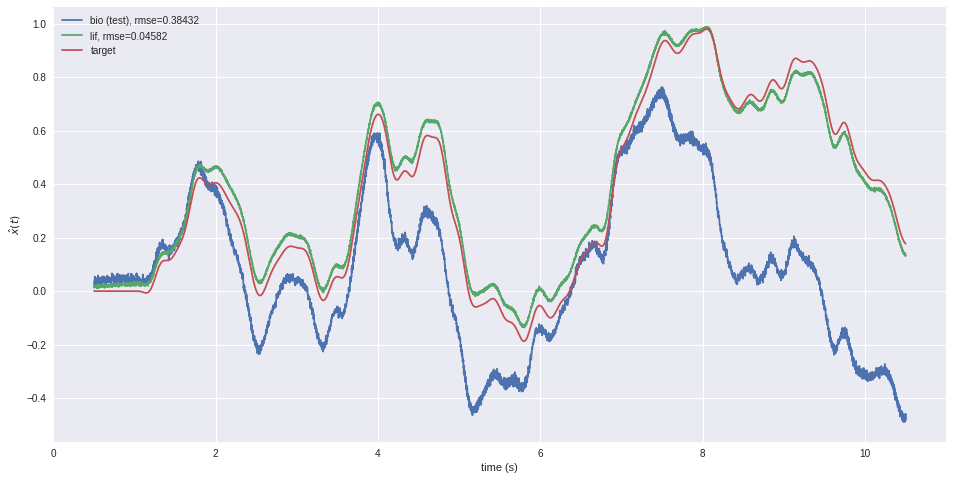

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:07.                                                 


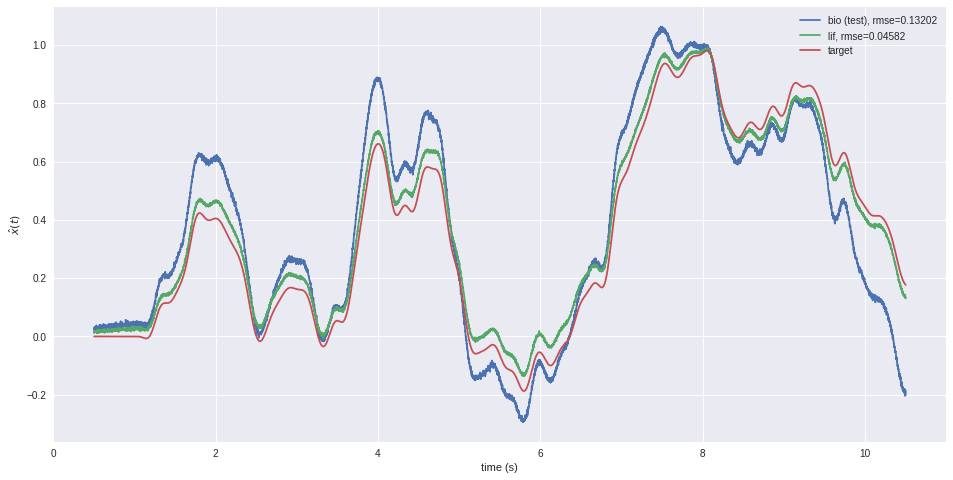

In [40]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    inter_type=nengo.LIF(),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]
d_feedforward_eval_points = sim.data[network.conn_lif].weights.T
d_inter_eval_points = sim.data[network.conn_inter].weights.T
d_ff_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter_oracle = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral)[0]

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    inter_type=nengo.LIF(),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=tau*norm_stim_train/norm_integ_train,
    d_feedforward=d_ff_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
d_ff_oracle_2 = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

times = sim.trange()[int(t_transient/dt):]
xhat_bio = sim.data[network.probe_bio][int(t_transient/dt):]
xhat_lif = sim.data[network.probe_lif][int(t_transient/dt):]
xhat_inter = sim.data[network.probe_inter][int(t_transient/dt):]
x_integ = sim.data[network.probe_integ][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
rmse_bio = rmse(xhat_bio, target)
rmse_lif = rmse(xhat_lif, target)

fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.plot(times, xhat_bio, label='bio, rmse=%.5f' % rmse_bio)
ax.plot(times, xhat_lif, label='lif, rmse=%.5f' % rmse_lif)
ax.plot(times, xhat_inter, label='inter')
ax.plot(times, x_integ, label='integ')
ax.plot(times, target, label='target')
ax.set(xlabel='time (s)', ylabel='$\hat{x}(t)$')
ax.legend()
plt.show()

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    inter_type=nengo.LIF(),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle,
    d_feedback=d_ff_oracle,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    inter_type=nengo.LIF(),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_ff_oracle_2,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Using a mismatched inter_type decreases finally accuracy, but not catastrophically

# Bioneurons

### inter_type = LIF()

In [42]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_train = 30.0
t_test = 10.0
signal_type_train = 'white_noise'
signal_type_test = 'white_noise'
seed_train = 3
seed_test = 2

signal_train, integral_train, norm_stim_train, norm_integ_train = get_signals(
    signal_type_train, network_seed, sim_seed, freq, seed_train, t_transient, t_train, max_freq, rms, tau, dt)
signal_test, integral_test, norm_stim_test, norm_integ_test = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:53:59.                                                 
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 1:08:00.                                                 


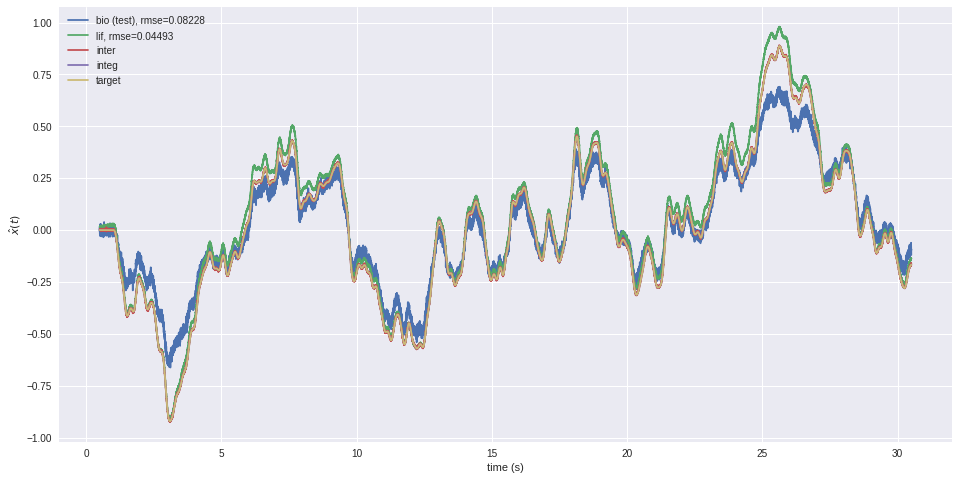

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:55:02.                                                 


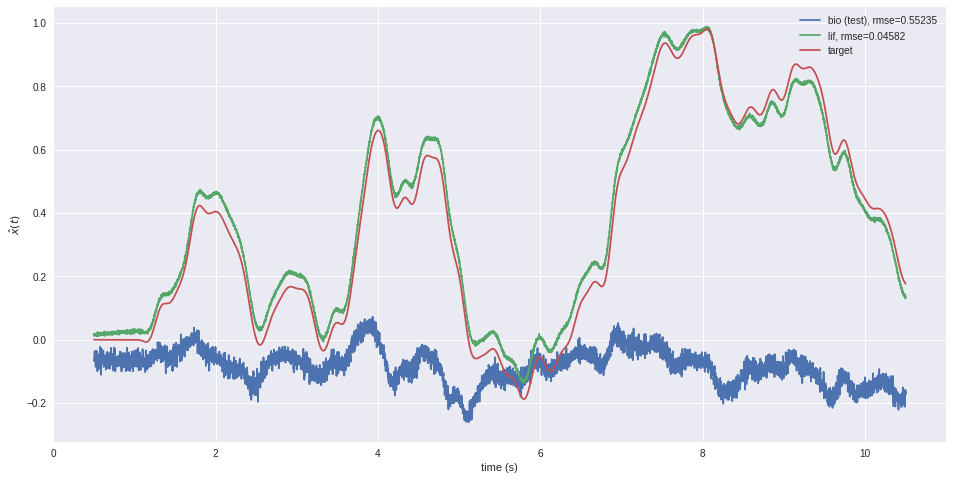

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:55:47.                                                 


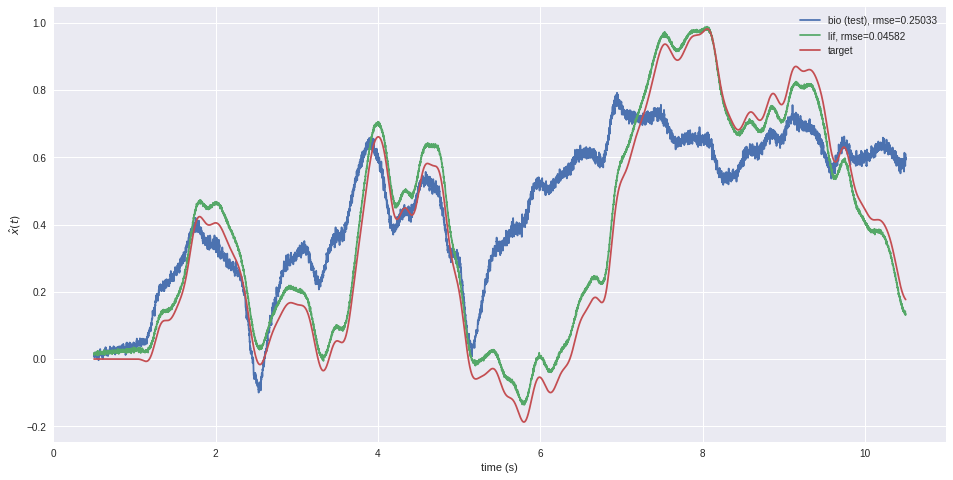

In [43]:
network = make_network(
    bio_type=BahlNeuron(),
    inter_type=nengo.LIF(),  # todo: inter adapts like bio (or is bio)
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]
d_feedforward_eval_points = sim.data[network.conn_lif].weights.T
d_inter_eval_points = sim.data[network.conn_inter].weights.T
d_ff_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter_oracle = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral)[0]

network = make_network(
    bio_type=BahlNeuron(),
    inter_type=nengo.LIF(),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=tau*norm_stim_train/norm_integ_train,
    d_feedforward=d_ff_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
d_ff_oracle_2 = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

times = sim.trange()[int(t_transient/dt):]
xhat_bio = sim.data[network.probe_bio][int(t_transient/dt):]
xhat_lif = sim.data[network.probe_lif][int(t_transient/dt):]
xhat_inter = sim.data[network.probe_inter][int(t_transient/dt):]
x_integ = sim.data[network.probe_integ][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
rmse_bio = rmse(xhat_bio, target)
rmse_lif = rmse(xhat_lif, target)

fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.plot(times, xhat_bio, label='bio, rmse=%.5f' % rmse_bio)
ax.plot(times, xhat_lif, label='lif, rmse=%.5f' % rmse_lif)
ax.plot(times, xhat_inter, label='inter')
ax.plot(times, x_integ, label='integ')
ax.plot(times, target, label='target')
ax.set(xlabel='time (s)', ylabel='$\hat{x}(t)$')
ax.legend()
plt.show()

network = make_network(
    bio_type=BahlNeuron(),
    inter_type=nengo.LIF(),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle,
    d_feedback=d_ff_oracle,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_network(
    bio_type=BahlNeuron(),
    inter_type=nengo.LIF(),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_ff_oracle_2,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

### inter_type = ALIF()

In [33]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_train = 10.0
t_test = 10.0
signal_type_train = 'sinusoids'
signal_type_test = 'white_noise'
seed_train = 3
seed_test = 2

signal_train, integral_train, norm_stim_train, norm_integ_train = get_signals(
    signal_type_train, network_seed, sim_seed, freq, seed_train, t_transient, t_train, max_freq, rms, tau, dt)
signal_test, integral_test, norm_stim_test, norm_integ_test = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)

In [ ]:
network = make_network(
    bio_type=BahlNeuron(),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]
d_feedforward_eval_points = sim.data[network.conn_lif].weights.T
d_inter_eval_points = sim.data[network.conn_inter].weights.T
d_ff_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter_oracle = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral)[0]

network = make_network(
    bio_type=BahlNeuron(),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=tau*norm_stim_train/norm_integ_train,
    d_feedforward=d_ff_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
d_ff_oracle_2 = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

times = sim.trange()[int(t_transient/dt):]
xhat_bio = sim.data[network.probe_bio][int(t_transient/dt):]
xhat_lif = sim.data[network.probe_lif][int(t_transient/dt):]
xhat_inter = sim.data[network.probe_inter][int(t_transient/dt):]
x_integ = sim.data[network.probe_integ][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integ = sim.data[network.probe_integ][int(t_transient/dt):]
rmse_bio = rmse(xhat_bio, target)
rmse_lif = rmse(xhat_lif, target)
rmse_inter = rmse(xhat_inter, integ)

fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.plot(times, xhat_bio, label='bio, rmse=%.5f' % rmse_bio)
ax.plot(times, xhat_lif, label='lif, rmse=%.5f' % rmse_lif)
ax.plot(times, xhat_inter, label='inter')
ax.plot(times, x_integ, label='integ, rmse=%.5f' % rmse_inter)
ax.plot(times, target, label='target')
ax.set(xlabel='time (s)', ylabel='$\hat{x}(t)$')
ax.legend()
plt.show()

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
[###################### Simulating... 67% #                     ] ETA: 0:05:31

Error about 2x larger than for ALIF

In [ ]:
from nengo.utils.matplotlib import rasterplot
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
rasterplot(sim.trange(), sim.data[network.probe_bio_spikes], ax=ax[0])
rasterplot(sim.trange(), sim.data[network.probe_lif_spikes], ax=ax[1])
plt.show()

No inactive bioneurons, but some fire more than LIFs

In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(16, 8))
sns.kdeplot(d_feedforward_eval_points.squeeze(), ax=ax)
sns.kdeplot(d_ff_oracle_bio.squeeze(), ax=ax)
sns.kdeplot(d_ff_oracle_bio_2.squeeze(), ax=ax)
sns.kdeplot(d_inter_eval_points.squeeze(), ax=ax2)
sns.kdeplot(d_inter_oracle.squeeze(), ax=ax2)
ax.set(title='bio')
ax2.set(title='inter')
plt.show()

d_ff_oracles are much less bimodal than either the nengo decoders or the d_ff_oracles from ALIFs (see plots above)

In [83]:
print len(np.intersect1d(np.where(-1e-5 < d_ff_oracle_bio), np.where(1e-5 > d_ff_oracle_bio)))
print len(np.intersect1d(np.where(-1e-5 < d_ff_oracle_bio_2), np.where(1e-5 > d_ff_oracle_bio_2)))

4
4


Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:02.                                                   
Simulating finished in 0:20:01.                                                 


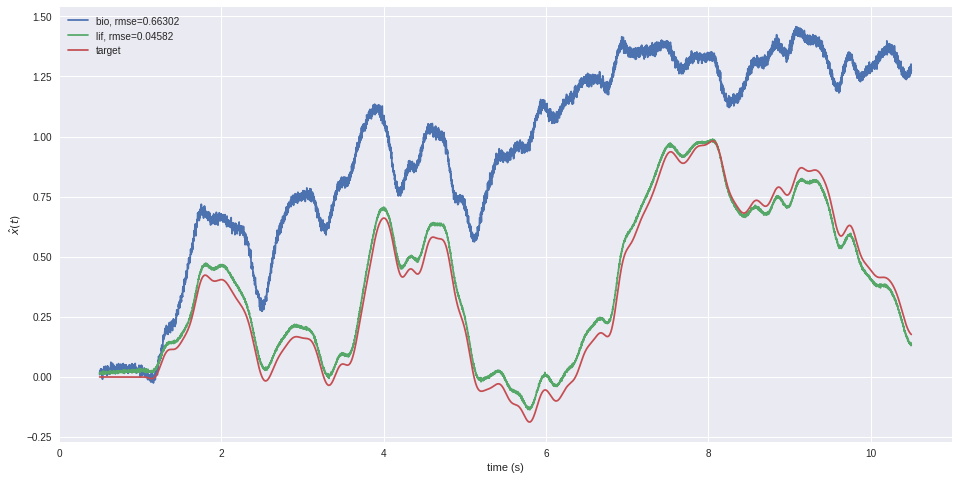

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:19:36.                                                 


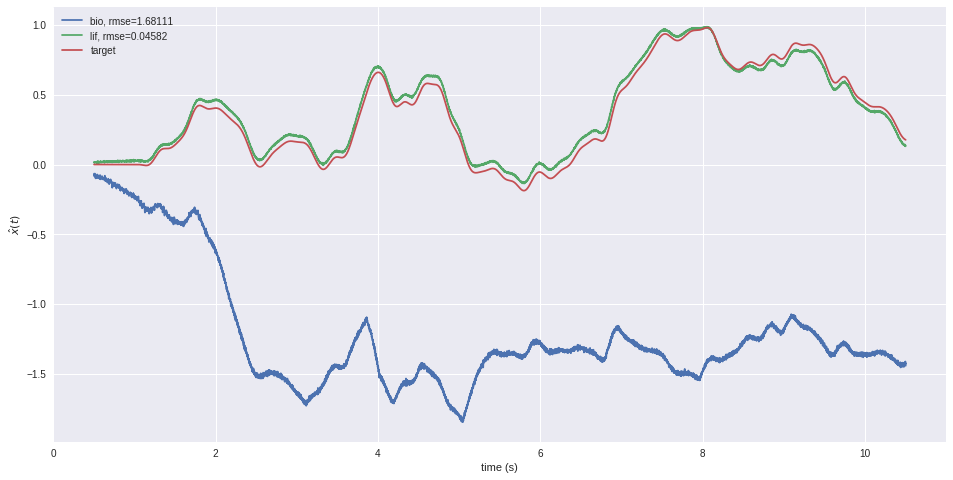

In [85]:
network = make_network(
    bio_type=BahlNeuron(),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle_bio,
    d_feedback=d_ff_oracle_bio,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_network(
    bio_type=BahlNeuron(),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle_bio_2,
    d_feedback=d_ff_oracle_bio_2,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:17:42.                                                 


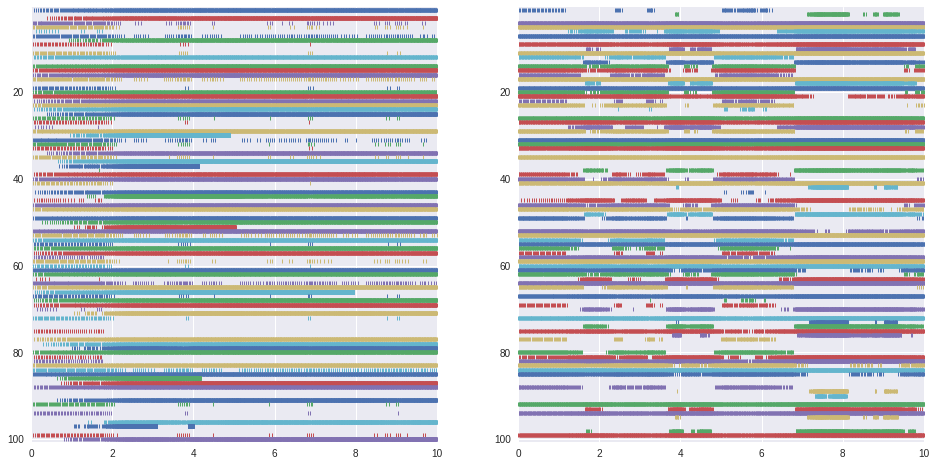

In [88]:
# network = make_network(
#     bio_type=BahlNeuron(),
#     inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
#     signal=signal_test,
#     integral=integral_test,
#     T_stim_oracle=0.0,
#     T_integ_oracle=1.0,
#     T_bio_bio=1.0,
#     T_inter_bio=0.0,
#     T_pre_bio=tau*norm_stim_test/norm_integ_test,
#     d_feedforward=d_ff_oracle_bio_2,
#     d_feedback=d_ff_oracle_bio_2,
#     d_inter=np.zeros((bio_neurons, dim)),
#     H_ff=nengo.Lowpass(tau)
# )

# with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
#     sim.run(10.0)

# from nengo.utils.matplotlib import rasterplot
# fig, ax = plt.subplots(1, 2, figsize=(16, 8))
# rasterplot(sim.trange(), sim.data[network.probe_bio_spikes], ax=ax[0])
# rasterplot(sim.trange(), sim.data[network.probe_lif_spikes], ax=ax[1])
# plt.show()

### inter_type = BahlNeuron()

 Define a network that can accept this inter_type, which requires a pre_inter ensemble

In [9]:
def make_bionetwork(
    pre_neurons=100,
    bio_neurons=100,
    tau=0.1,
    tau_pre=0.01,
    dt=0.001,
    min_rate=150,
    max_rate=200,
    radius=1,
    dim=1,
    pre_seed=1,
    bio_seed=2,
    conn_seed=3,
    network_seed=4,
    sim_seed=5,
    post_seed=6,
    inter_seed=7,
    conn2_seed=9,
    conn3_seed=10,
    bio_type=BahlNeuron(),
    inter_type=BahlNeuron(),
    signal=[],
    integral=[],
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    d_feedforward=np.zeros((100, 1)),
    d_feedback=np.zeros((100,1)),
    d_inter=np.zeros((100,1)),
    H_ff=nengo.Lowpass(0.1)):

    """
    Define the network
    """
    with nengo.Network(seed=network_seed) as network:
        stim = nengo.Node(lambda t: signal[int(t/dt)])
        integ = nengo.Node(lambda t: integral[int(t/dt)])
        pre = nengo.Ensemble(
            n_neurons=pre_neurons,
            dimensions=dim,
            seed=pre_seed,
            neuron_type=nengo.LIF(),
            radius=radius,
            label='pre')
        bio = nengo.Ensemble(
            n_neurons=bio_neurons,
            dimensions=dim,
            seed=bio_seed,
            neuron_type=bio_type,
            radius=radius,
            max_rates=nengo.dists.Uniform(min_rate, max_rate),
            label='bio')
        pre_inter = nengo.Ensemble(
            n_neurons=pre_neurons,
            dimensions=dim,
            seed=pre_seed,
            neuron_type=nengo.LIF(),
            radius=radius,
            label='pre_inter')
        inter = nengo.Ensemble(
            n_neurons=bio_neurons,
            dimensions=dim,
            seed=bio_seed,
            neuron_type=inter_type,
            max_rates=nengo.dists.Uniform(min_rate, max_rate),
            radius=radius,
            label='inter')
        lif = nengo.Ensemble(
            n_neurons=bio_neurons,
            dimensions=dim,
            seed=bio_seed,
            max_rates=nengo.dists.Uniform(min_rate, max_rate),
            radius=radius,
            neuron_type=nengo.LIF(),
            label='lif')
        oracle = nengo.Node(size_in=dim)
        temp = nengo.Node(size_in=dim)
        temp2 = nengo.Node(size_in=dim)

        ff_solver = nengo.solvers.NoSolver(d_feedforward)
        fb_solver = nengo.solvers.NoSolver(d_feedback)
        inter_solver = nengo.solvers.NoSolver(d_inter) if not isinstance(d_inter, nengo.solvers.Solver) else d_inter  # lol 

        nengo.Connection(stim, pre, synapse=None)
        pre_bio = nengo.Connection(pre, bio,
            weights_bias_conn=True,
            seed=conn_seed,
            synapse=tau,
            transform=T_pre_bio)
        bio_bio = nengo.Connection(bio, bio,
            seed=conn2_seed,
            synapse=tau,
            solver=fb_solver,
            transform=T_bio_bio)

        pre_lif = nengo.Connection(pre, lif,
            synapse=tau,
            transform=T_pre_bio)
        nengo.Connection(lif, lif,
            synapse=tau)

        stim_oracle = nengo.Connection(stim, oracle,
            synapse=tau,  
            transform=T_stim_oracle) # connection for training H(s) w/ feedforward pass
        integ_oracle = nengo.Connection(integ, oracle,
            synapse=None,  
            transform=T_integ_oracle) # connection for training d_feedback w/ feedback pass 

        integ_pre = nengo.Connection(integ, pre_inter,
            seed=conn3_seed,
            synapse=None)
        pre_inter = nengo.Connection(pre_inter, inter,
            weights_bias_conn=True,
            seed=conn3_seed,
            synapse=tau_pre)
        nengo.Connection(inter, bio,
            seed=conn3_seed,
            synapse=tau,
            transform=T_inter_bio,
            solver=inter_solver)  

        conn_lif = nengo.Connection(lif, temp, synapse=tau)

        probe_bio_spikes = nengo.Probe(bio.neurons, 'spikes')
        probe_lif_activity = nengo.Probe(lif.neurons, 'spikes', synapse=tau)
        probe_bio_activity = nengo.Probe(bio.neurons, 'spikes', synapse=H_ff)
        probe_oracle = nengo.Probe(oracle, synapse=H_ff)
        probe_bio = nengo.Probe(bio, synapse=tau, solver=ff_solver)
        probe_lif = nengo.Probe(lif, synapse=tau)
        probe_inter = nengo.Probe(inter, synapse=tau, solver=inter_solver)
        probe_inter_activity = nengo.Probe(inter.neurons, 'spikes', synapse=tau)
        probe_inter_spikes = nengo.Probe(inter.neurons, 'spikes', synapse=None)
        probe_pre = nengo.Probe(pre, synapse=tau)
        probe_integ = nengo.Probe(integ, synapse=tau)  # TODO: make sure unfiltered not needed
        probe_stim = nengo.Probe(stim, synapse=None)

    network.bio = bio
    network.conn_lif = conn_lif
    network.bio_bio = bio_bio
    network.stim = stim
    network.integ = integ
    network.pre_bio = pre_bio
    network.pre_lif = pre_lif
    network.stim_oracle = stim_oracle
    network.integ_oracle = integ_oracle
    network.probe_bio_spikes = probe_bio_spikes
    network.probe_bio_activity = probe_bio_activity
    network.probe_oracle = probe_oracle
    network.probe_bio = probe_bio
    network.probe_lif = probe_lif
    network.probe_lif_activity = probe_lif_activity
    network.probe_inter = probe_inter
    network.probe_inter_activity = probe_inter_activity
    network.probe_inter_spikes = probe_inter_spikes
    network.probe_pre = probe_pre
    network.probe_integ = probe_integ
    network.probe_stim = probe_stim

    return network

In [79]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_train = 30.0
t_test = 10.0
signal_type_train = 'sinusoids'
signal_type_test = 'white_noise'
seed_train = 3
seed_test = 2

signal_train, integral_train, norm_stim_train, norm_integ_train = get_signals(
    signal_type_train, network_seed, sim_seed, freq, seed_train, t_transient, t_train, max_freq, rms, tau, dt)
signal_test, integral_test, norm_stim_test, norm_integ_test = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)

In [ ]:
network = make_bionetwork(
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]
d_ff_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter_oracle = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral)[0]

network = make_bionetwork(
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=tau*norm_stim_train/norm_integ_train,
    d_feedforward=d_ff_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
d_ff_oracle_2 = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

times = sim.trange()[int(t_transient/dt):]
xhat_bio = sim.data[network.probe_bio][int(t_transient/dt):]
xhat_lif = sim.data[network.probe_lif][int(t_transient/dt):]
xhat_inter = sim.data[network.probe_inter][int(t_transient/dt):]
x_integ = sim.data[network.probe_integ][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integ = sim.data[network.probe_integ][int(t_transient/dt):]
rmse_bio = rmse(xhat_bio, target)
rmse_lif = rmse(xhat_lif, target)
rmse_inter = rmse(xhat_inter, integ)

fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.plot(times, xhat_bio, label='bio, rmse=%.5f' % rmse_bio)
ax.plot(times, xhat_lif, label='lif, rmse=%.5f' % rmse_lif)
ax.plot(times, xhat_inter, label='inter')
ax.plot(times, x_integ, label='integ, rmse=%.5f' % rmse_inter)
ax.plot(times, target, label='target')
ax.set(xlabel='time (s)', ylabel='$\hat{x}(t)$')
ax.legend()
plt.show()

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:02.                                                   
Simulating finished in 1:38:10.                                                 
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:02.                                                   
Simulating finished in 2:22:18.                                                 


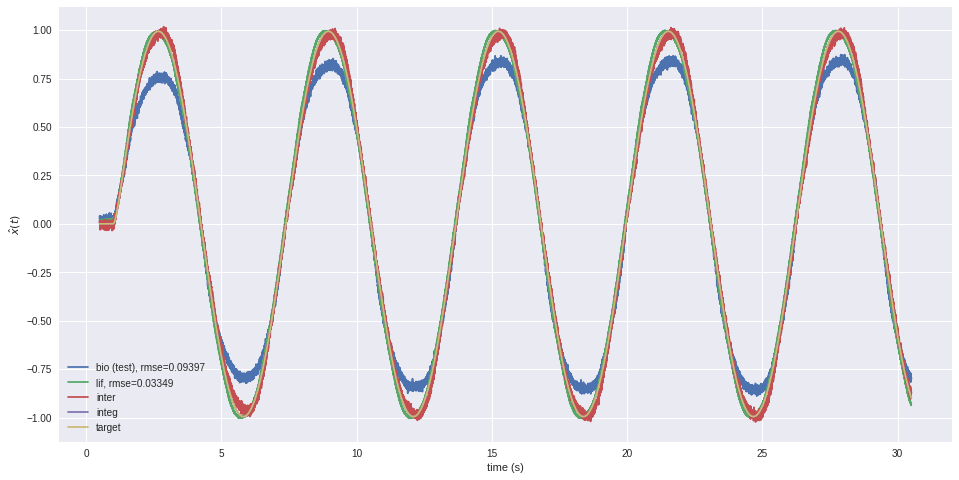

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:02.                                                   
Simulating finished in 2:03:52.                                                 


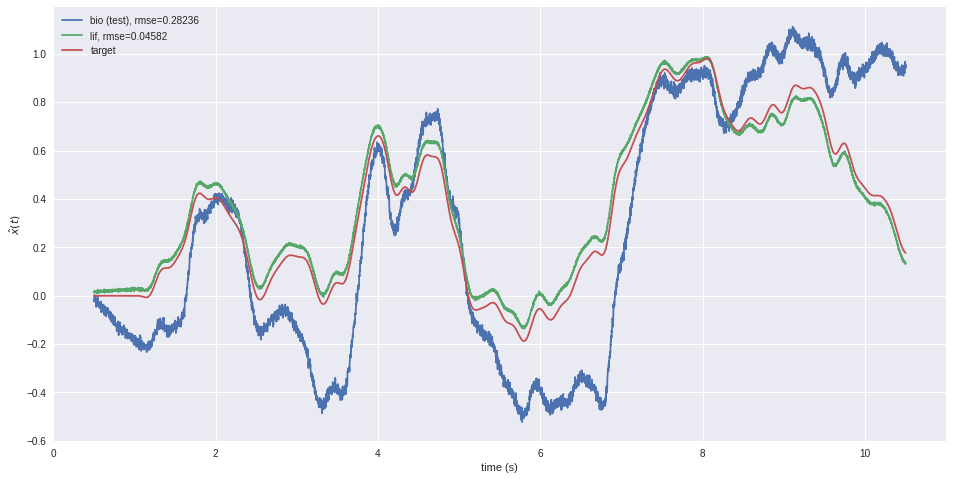

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:02.                                                   
Simulating finished in 2:01:44.                                                 


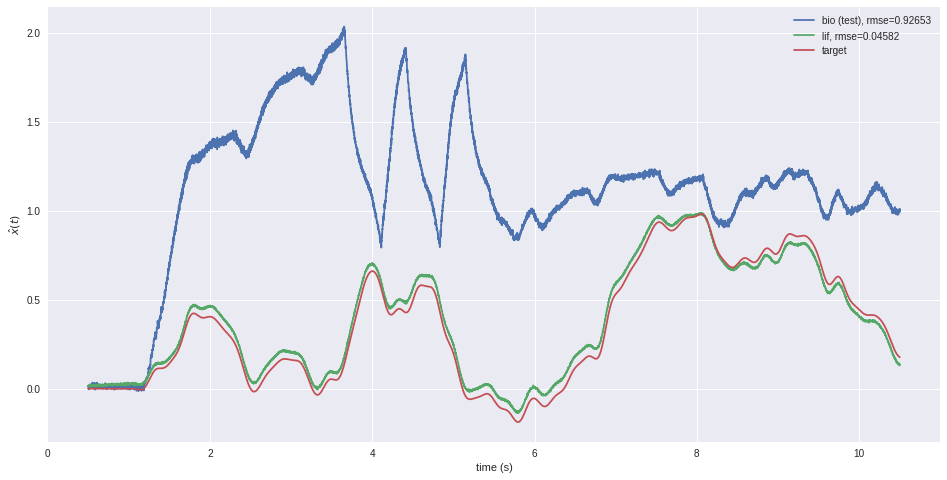

In [80]:
network = make_bionetwork(
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle,
    d_feedback=d_ff_oracle,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_bionetwork(
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_ff_oracle_2,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Conclusion: an effective method for computing feedback decoders, d_fb, for LIFs/ALIFs is to:
1. Compute readout decoders d_ff_oracle, using either lowpass filters or evolved filters, for the "bio" and "inter" populations
2. Feed the target signal "integral" into "inter", then send those training spikes to "bio" using d_inter = d_ff_oracle
3. Collect spikes from "bio" in this ideally-stimulated recurrent circuit, then calculate a new set of readout filters d_ff_oracle_2 (again, using either a lowpass or evolved filter)
4. Remove the training spikes and recurrently connect "bio" with d_fb = d_ff_oracle_2, decoding with d_ff = d_ff_oracle_2 as well.

Unfortunately, this method does not work for bioneurons, regardless of inter_type.

# Evolve d_fb for ALIF

### Compute d_ff and d_fb as above

In [64]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_train = 30.0
t_evo = 30.0
t_test = 10.0
signal_type_train = 'sinusoids'
signal_type_evo = 'sinusoids'
signal_type_test = 'white_noise'
seed_train = 3
seed_test = 2
seed_evo = 1

signal_train, integral_train, norm_stim_train, norm_integ_train = get_signals(
    signal_type_train, network_seed, sim_seed, freq, seed_train, t_transient, t_train, max_freq, rms, tau, dt)
signal_test, integral_test, norm_stim_test, norm_integ_test = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)
signal_evo, integral_evo, norm_stim_evo, norm_integ_evo = get_signals(
    signal_type_evo, network_seed, sim_seed, freq, seed_evo, t_transient, t_evo, max_freq, rms, tau, dt)

In [65]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]
d_feedforward_eval_points = sim.data[network.conn_lif].weights.T
d_inter_eval_points = sim.data[network.conn_inter].weights.T
d_ff_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter_oracle = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral)[0]

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=tau*norm_stim_train/norm_integ_train,
    d_feedforward=d_ff_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
d_ff_oracle_2 = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:35.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:28.                                                 


Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


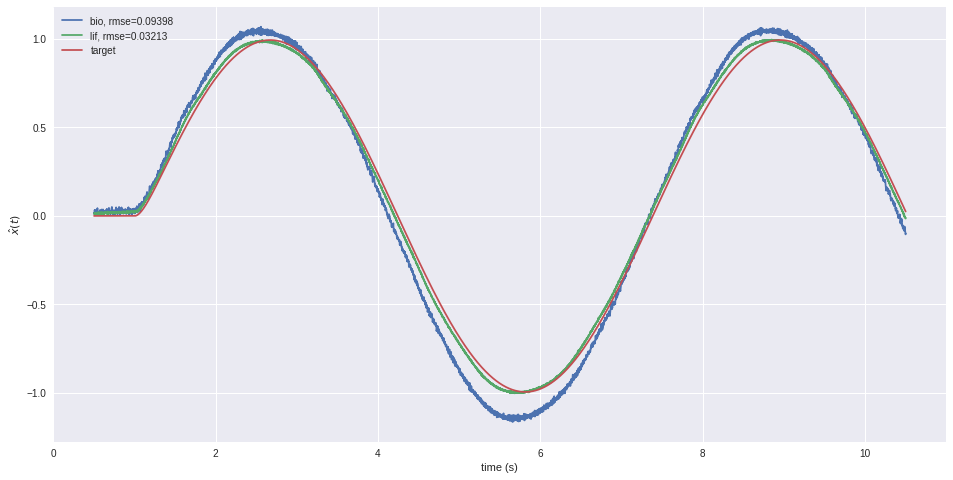

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:09.                                                 


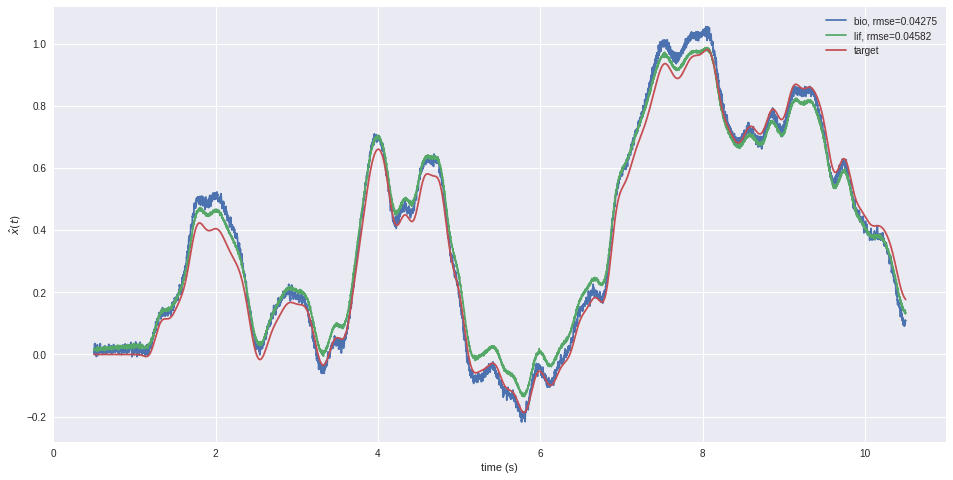

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


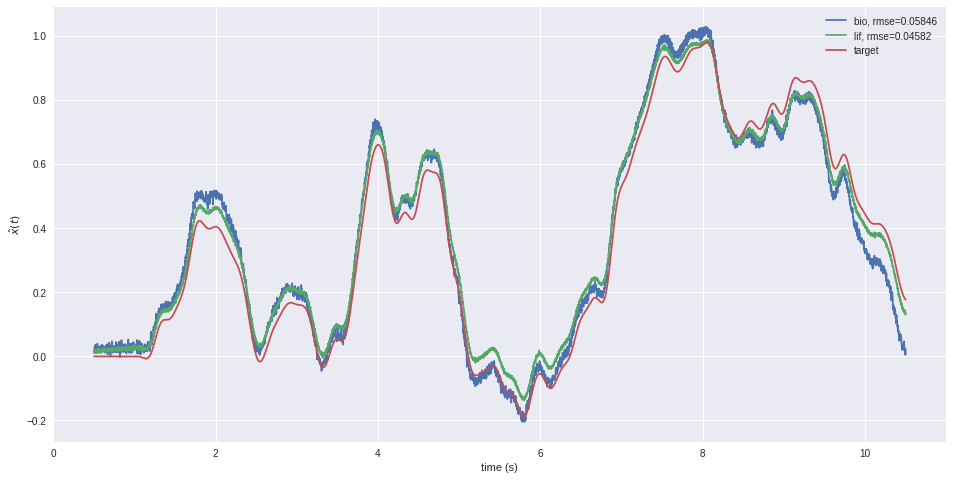

In [66]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_evo,
    integral=integral_evo,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_evo/norm_integ_evo,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_ff_oracle_2,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle,
    d_feedback=d_ff_oracle,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_ff_oracle_2,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9


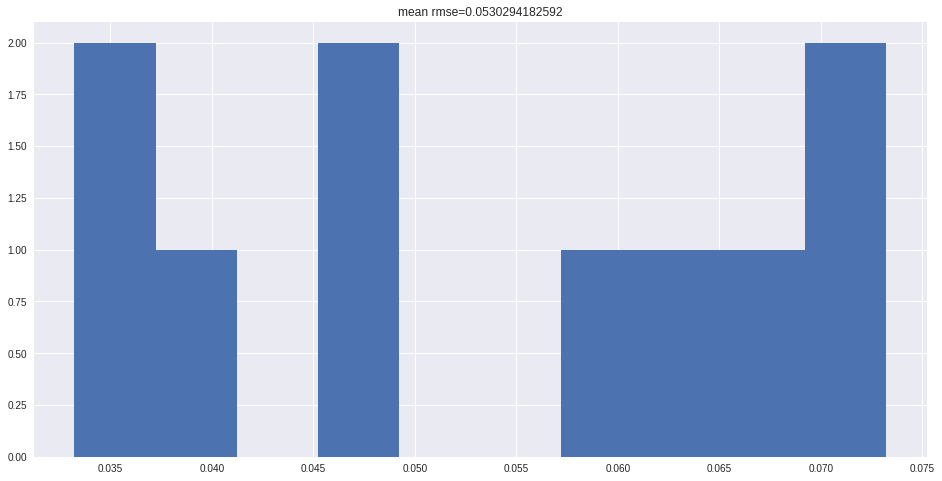

In [77]:
n_trials = 10
t_test = 10.0
signal_seed_0 = 100
rmses = test_n_trials(network, n_trials, t_transient, t_test, sim_seed,
                  network_seed, max_freq, rms, signal_seed_0, tau, dt)

### Initial guess at d_fb = d_ff_oracle_2

generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19


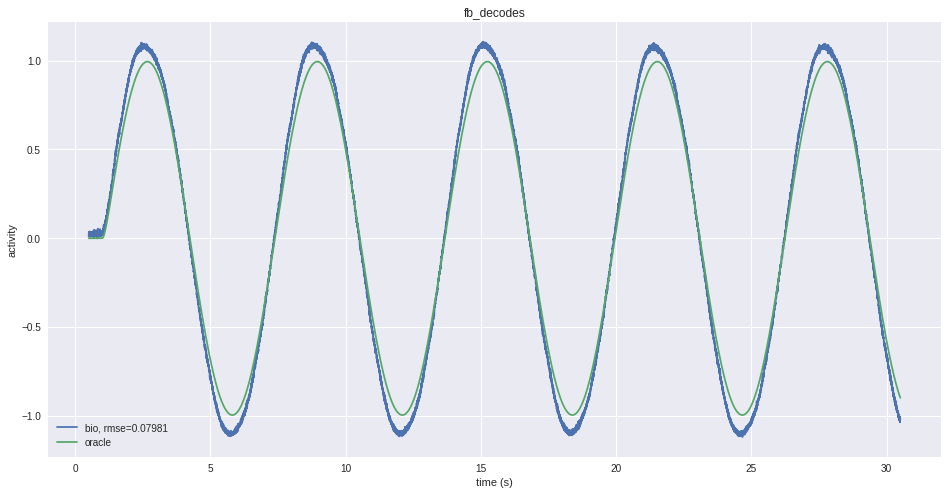

/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


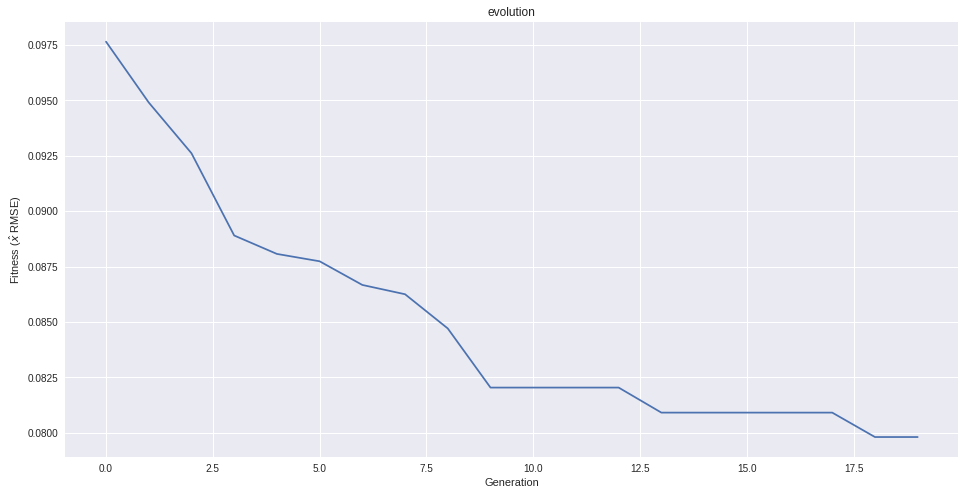

Process PoolWorker-5:
Process PoolWorker-4:
Process PoolWorker-6:
Process PoolWorker-2:
Process PoolWorker-1:
Process PoolWorker-7:
Process PoolWorker-10:
Traceback (most recent call last):
Process PoolWorker-3:
Process PoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/multiprocess/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Process PoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
    self.run()
  File "/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/multiprocess/process.py", line 258, in _bootstrap
  File "/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/multiprocess/process.py", line 258, in _bootstrap
Traceback (most recent call last):
  File "/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/multiprocess/process.py", line 258, in _bootstrap
Traceback (

In [78]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_evo,
    integral=integral_evo,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_evo/norm_integ_evo,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_ff_oracle_2,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

n_processes = 10
evo_popsize = 10
evo_gen_feedback = 20
evo_seed = 2
decoders_delta = 2e-5
mutation_rate = 0.01

d_ff = d_ff_oracle_2
d_fb_init = d_ff_oracle_2
zeros_feedforward = []
poles_feedforward = [-1.0 / tau]

d_fb_evo = train_feedback(
    network,
    sim_seed,
    t_transient,
    t_evo,
    dt,
    reg,
    n_processes,
    evo_popsize,
    evo_gen_feedback,
    evo_seed,
    zeros_feedforward,
    poles_feedforward,
    d_ff,
    d_fb_init,
    network.bio_bio,
    decoders_delta,
    mutation_rate,
    network.probe_bio_activity,
    network.probe_oracle)

In [79]:
# network = make_network(
#     bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
#     inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
#     signal=signal_train,
#     integral=integral_train,
#     T_stim_oracle=0.0,
#     T_integ_oracle=1.0,
#     T_bio_bio=1.0,
#     T_inter_bio=0.0,
#     T_pre_bio=tau*norm_stim_train/norm_integ_train,
#     d_feedforward=d_ff_oracle_2,
#     d_feedback=d_fb_evo,
#     d_inter=np.zeros((bio_neurons, dim)),
#     H_ff=nengo.Lowpass(tau)
# )

# with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
#     sim.run(t_transient + t_train)
    
# act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
# target = sim.data[network.probe_oracle][int(t_transient/dt):]
# d_ff_oracle_3 = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

# network = make_network(
#     bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
#     inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
#     signal=signal_test,
#     integral=integral_test,
#     T_stim_oracle=0.0,
#     T_integ_oracle=1.0,
#     T_bio_bio=1.0,
#     T_inter_bio=0.0,
#     T_pre_bio=tau*norm_stim_test/norm_integ_test,
#     d_feedforward=d_ff_oracle_3,
#     d_feedback=d_fb_evo,
#     d_inter=np.zeros((bio_neurons, dim)),
#     H_ff=nengo.Lowpass(tau)
# )

trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9


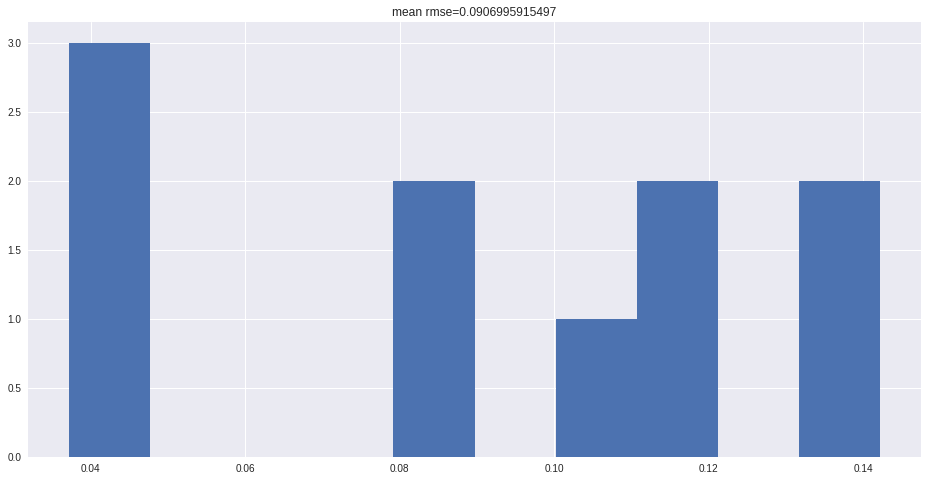

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:11.                                                 


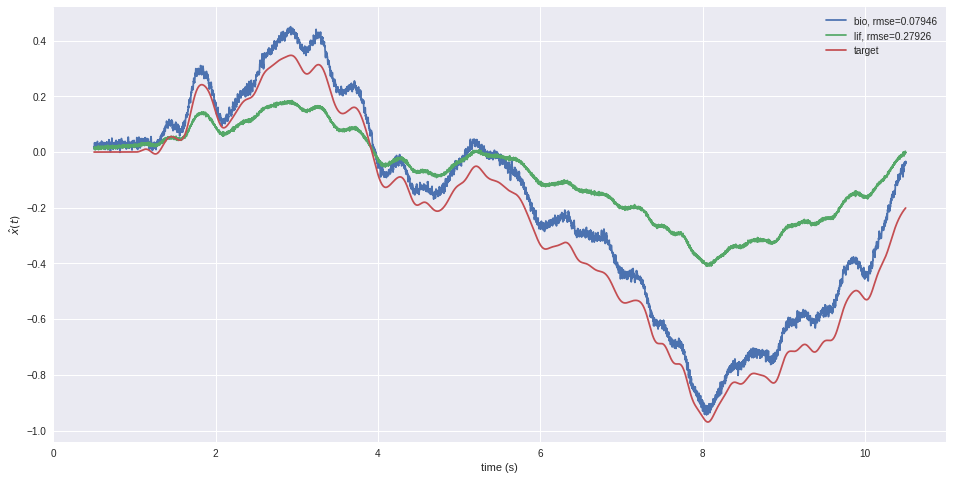

In [80]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_train/norm_integ_train,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_fb_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

n_trials = 10
t_test = 10.0
signal_seed_0 = 100
rmses = test_n_trials(network, n_trials, t_transient, t_test, sim_seed,
                  network_seed, max_freq, rms, signal_seed_0, tau, dt)

run_plot(network, t_transient, t_test, dt, sim_seed)

### Evolve with signal_evo = 'white_noise'

In [10]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_train = 10.0
t_evo = 20.0
t_test = 10.0
signal_type_train = 'sinusoids'
signal_type_evo = 'white_noise'
signal_type_test = 'white_noise'
seed_train = 3
seed_test = 2
seed_evo = 1

signal_train, integral_train, norm_stim_train, norm_integ_train = get_signals(
    signal_type_train, network_seed, sim_seed, freq, seed_train, t_transient, t_train, max_freq, rms, tau, dt)
signal_test, integral_test, norm_stim_test, norm_integ_test = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)
signal_evo, integral_evo, norm_stim_evo, norm_integ_evo = get_signals(
    signal_type_evo, network_seed, sim_seed, freq, seed_evo, t_transient, t_evo, max_freq, rms, tau, dt)

/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


In [11]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]
d_feedforward_eval_points = sim.data[network.conn_lif].weights.T
d_inter_eval_points = sim.data[network.conn_inter].weights.T
d_ff_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter_oracle = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral)[0]

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=tau*norm_stim_train/norm_integ_train,
    d_feedforward=d_ff_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
d_ff_oracle_2 = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:12.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:14.                                                 


Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
generation 0
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:30.                                                 
Building finished in 0:00:01.                                                   
Simulating fini

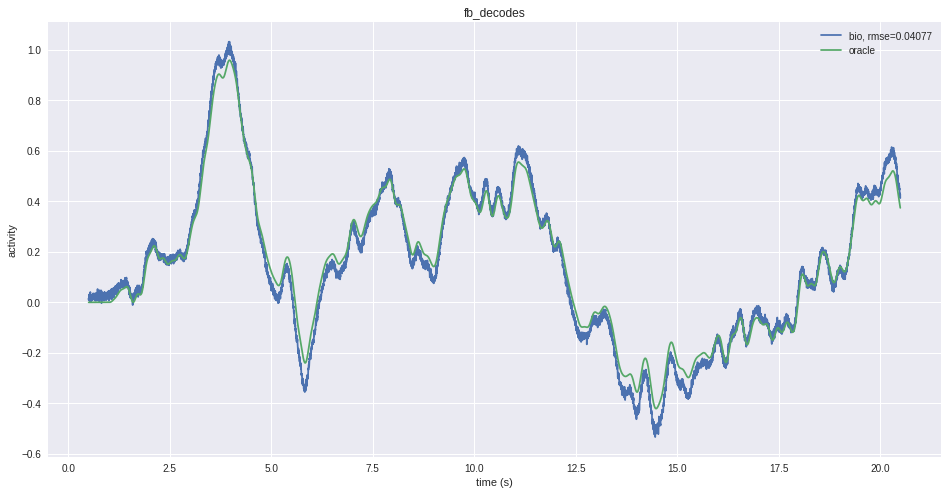

/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


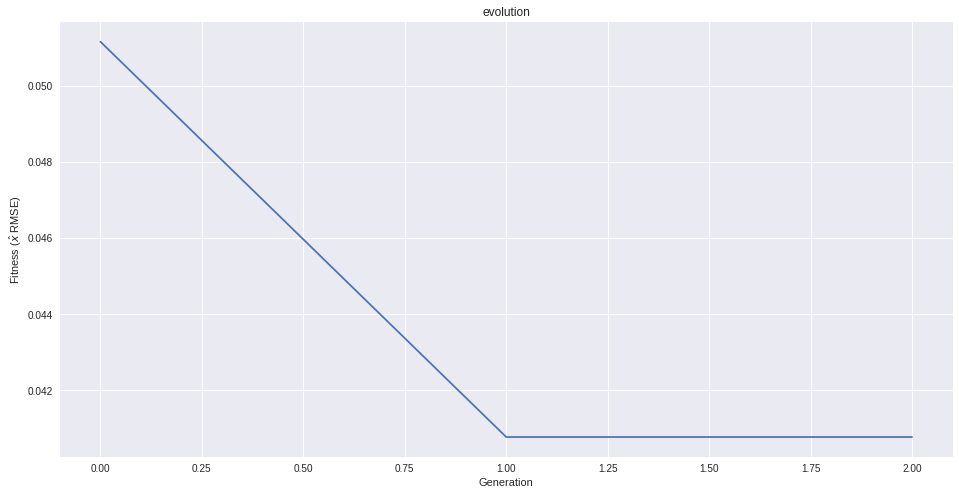

In [12]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_evo,
    integral=integral_evo,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_evo/norm_integ_evo,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_ff_oracle_2,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

n_processes = 10
evo_popsize = 20
evo_gen_feedback = 3
evo_seed = 2
decoders_delta = 1e-5
mutation_rate = 0.01

d_ff = d_ff_oracle_2
d_fb_init = d_ff_oracle_2
zeros_feedforward = []
poles_feedforward = [-1.0 / tau]

d_fb_evo = train_feedback(
    network,
    sim_seed,
    t_transient,
    t_evo,
    dt,
    reg,
    n_processes,
    evo_popsize,
    evo_gen_feedback,
    evo_seed,
    zeros_feedforward,
    poles_feedforward,
    d_ff,
    d_fb_init,
    network.bio_bio,
    decoders_delta,
    mutation_rate,
    network.probe_bio_activity,
    network.probe_oracle)

In [ ]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_train/norm_integ_train,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_fb_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

n_trials = 30
t_test = 10.0
signal_seed_0 = 100
rmses = test_n_trials(network, n_trials, t_transient, t_test, sim_seed,
                  network_seed, max_freq, rms, signal_seed_0, tau, dt)

In [ ]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_fb_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

### Evolve d_fb for bioneurons

In [10]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_train = 10.0
t_evo = 10.0
t_test = 10.0
signal_type_train = 'sinusoids'
signal_type_evo = 'white_noise'
signal_type_test = 'white_noise'
seed_train = 3
seed_test = 2
seed_evo = 1

signal_train, integral_train, norm_stim_train, norm_integ_train = get_signals(
    signal_type_train, network_seed, sim_seed, freq, seed_train, t_transient, t_train, max_freq, rms, tau, dt)
signal_test, integral_test, norm_stim_test, norm_integ_test = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)
signal_evo, integral_evo, norm_stim_evo, norm_integ_evo = get_signals(
    signal_type_evo, network_seed, sim_seed, freq, seed_evo, t_transient, t_evo, max_freq, rms, tau, dt)

/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


In [11]:
network = make_network(
    bio_type=BahlNeuron(),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]
d_feedforward_eval_points = sim.data[network.conn_lif].weights.T
d_inter_eval_points = sim.data[network.conn_inter].weights.T
d_ff_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter_oracle = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral)[0]

network = make_network(
    bio_type=BahlNeuron(),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=tau*norm_stim_train/norm_integ_train,
    d_feedforward=d_ff_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
d_ff_oracle_2 = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:02.                                                   
Simulating finished in 0:46:45.                                                 
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:02.                                                   
Simulating finished in 0:52:41.                                                 


generation 0
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finish

Building finished in 0:00:02.                                                   
Building finished in 0:00:02.                                                   
Building finished in 0:00:02.                                                   
Building finished in 0:00:02.                                                   
Building finished in 0:00:02.                                                   
Building finished in 0:00:02.                                                   
Building finished in 0:00:02.                                                   
Building finished in 0:00:02.                                                   
Building finished in 0:00:02.                                                   
Building finished in 0:00:02.                                                   
Simulating finished in 2:08:19.                                                 
Simulating finished in 2:08:20.                                                 
Simulating finished in 2:08:

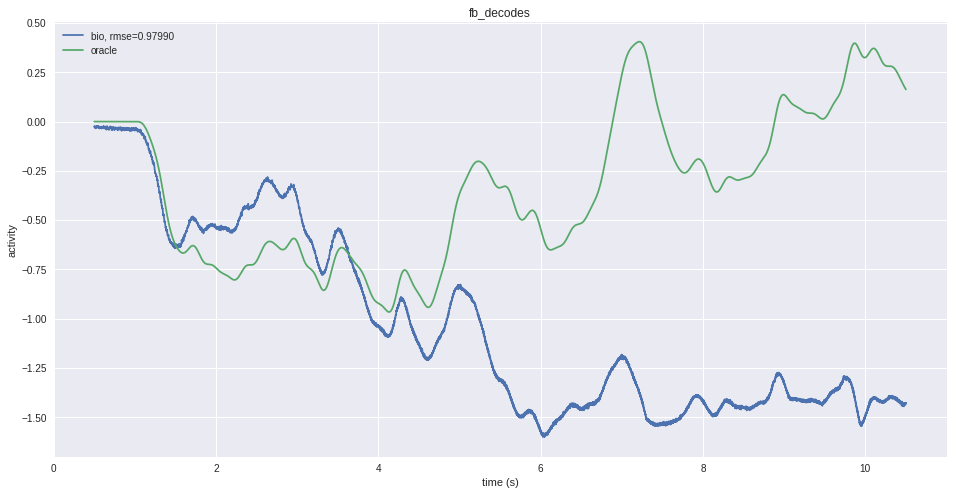

/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


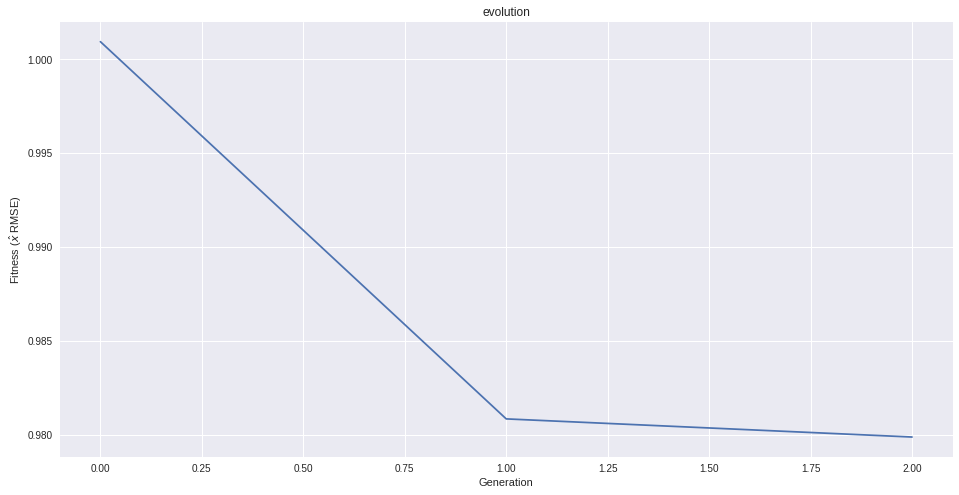

In [12]:
network = make_network(
    bio_type=BahlNeuron(),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_evo,
    integral=integral_evo,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_evo/norm_integ_evo,
    d_feedforward=d_ff_oracle,
    d_feedback=d_ff_oracle,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

n_processes = 10
evo_popsize = 10
evo_gen_feedback = 3
evo_seed = 2
decoders_delta = 2e-6
mutation_rate = 0.03

d_ff = d_ff_oracle
d_fb_init = d_ff_oracle
zeros_feedforward = []
poles_feedforward = [-1.0 / tau]

d_fb_evo = train_feedback(
    network,
    sim_seed,
    t_transient,
    t_evo,
    dt,
    reg,
    n_processes,
    evo_popsize,
    evo_gen_feedback,
    evo_seed,
    zeros_feedforward,
    poles_feedforward,
    d_ff,
    d_fb_init,
    network.bio_bio,
    decoders_delta,
    mutation_rate,
    network.probe_bio_activity,
    network.probe_oracle)

In [ ]:
network = make_network(
    bio_type=BahlNeuron(),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_train/norm_integ_train,
    d_feedforward=d_ff_oracle,
    d_feedback=d_fb_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

n_trials = 3
t_test = 10.0
signal_seed_0 = 100
rmses = test_n_trials(network, n_trials, t_transient, t_test, sim_seed,
                  network_seed, max_freq, rms, signal_seed_0, tau, dt)

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:47:35.                                                 


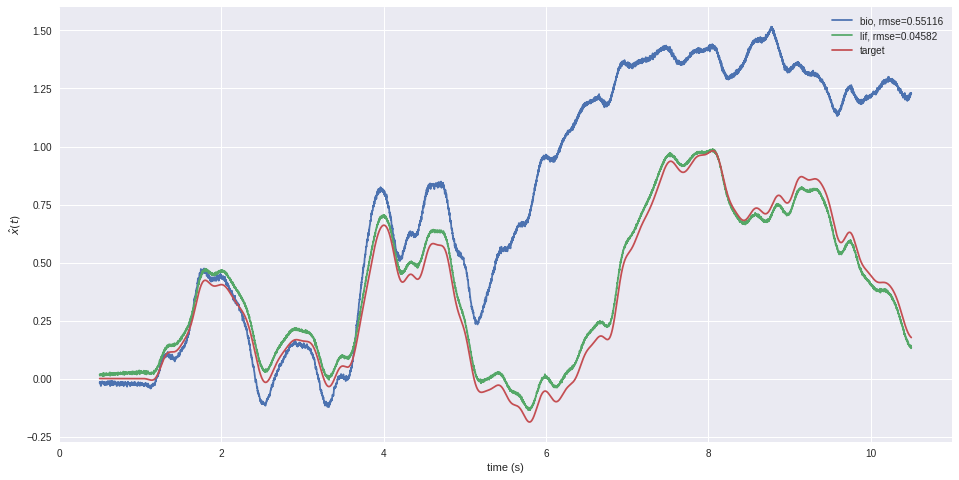

In [13]:
network = make_network(
    bio_type=BahlNeuron(),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=tau*norm_stim_test/norm_integ_test,
    d_feedforward=d_ff_oracle,
    d_feedback=d_fb_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)